In [1]:
import os
import itertools
import logging
logging.basicConfig()
import tempfile

from datetime import datetime
from collections import namedtuple

import xarray as xr
import matplotlib.pyplot as plt

logging.getLogger("cicliminds_lib").setLevel(logging.INFO)
from cicliminds_lib.query.files import get_datasets
from cicliminds_lib.query.datasets import get_list_of_files
from cicliminds_lib.query.models import list_model_configurations

from cicliminds_lib.bindings import remove_grid_from_data

from cicliminds_lib.masks.masks import get_oceans_mask
from cicliminds_lib.masks.masks import get_antarctica_mask

from cicliminds_lib.plotting.plot_recipes import plot_means_of_hists
from cicliminds_lib.plotting.plot_recipes import plot_means_of_hists_diff
from cicliminds_lib.plotting.plot_recipes import plot_hists_of_means
from cicliminds_lib.plotting.plot_recipes import plot_hists_of_means_diff
from cicliminds_lib.plotting.plot_recipes import plot_hist_of_timeavgs
from cicliminds_lib.plotting.plot_recipes import plot_hist_of_timeavgs_diff


plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 8
plt.rcParams["xtick.major.width"] = 1.6
plt.rcParams["xtick.minor.width"] = 0.8
plt.rcParams["xtick.minor.size"] = 4
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.width"] = 1.6
plt.rcParams["ytick.minor.width"] = 0.8
plt.rcParams["ytick.major.size"] = 8
plt.rcParams["ytick.minor.size"] = 4
plt.rcParams["font.size"] = 16
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 5
plt.rcParams["savefig.dpi"] = 300/2.4
plt.rcParams["savefig.transparent"] = False
plt.rcParams["savefig.facecolor"] = "white"

In [2]:
OUTPUT_DIR = "meanplots-global_fig"

In [3]:
DATA_DIR = os.environ["DATA_DIR"]
display(DATA_DIR)

'/home/viktoana/projects/cicero/data/Climdex_base1981-2010'

In [4]:
DATASETS = get_datasets(DATA_DIR)
DATASETS.head()

variable frequency  \
path                                                                         
/home/viktoana/projects/cicero/data/Climdex_bas...  altcddETCCDI        yr   
/home/viktoana/projects/cicero/data/Climdex_bas...  altcddETCCDI        yr   
/home/viktoana/projects/cicero/data/Climdex_bas...  altcddETCCDI        yr   
/home/viktoana/projects/cicero/data/Climdex_bas...  altcddETCCDI        yr   
/home/viktoana/projects/cicero/data/Climdex_bas...  altcddETCCDI        yr   

                                                          model    scenario  \
path                                                                          
/home/viktoana/projects/cicero/data/Climdex_bas...  CNRM-ESM2-1  historical   
/home/viktoana/projects/cicero/data/Climdex_bas...   ACCESS-CM2  historical   
/home/viktoana/projects/cicero/data/Climdex_bas...  CNRM-ESM2-1      ssp126   
/home/viktoana/projects/cicero/data/Climdex_bas...   ACCESS-CM2      ssp126   
/home/viktoana/projects/cicero/data/Climdex_bas...  CNRM-ESM2-1      ssp245   

                                                   init_params timespan_from  \
path                                                                           
/home/viktoana/projects/cicero/data/Climdex_bas...    r1i1p1f2          1850   
/home/viktoana/projects/cicero/data/Climdex_bas...    r1i1p1f1          1850   
/home/viktoana/projects/cicero/data/Climdex_bas...    r1i1p1f2          2015   
/home/viktoana/projects/cicero/data/Climdex_bas...    r1i1p1f1          2015   
/home/viktoana/projects/cicero/data/Climdex_bas...    r1i1p1f2          2015   

                                                   timespan_to  
path                                                            
/home/viktoana/projects/cicero/data/Climdex_bas...        2014  
/home/viktoana/projects/cicero/data/Climdex_bas...        2014  
/home/viktoana/projects/cicero/data/Climdex_bas...        2100  
/home/viktoana/projects/cicero/data/Climdex_bas...        2100  
/home/viktoana/projects/cicero/data/Climdex_bas...        2100

In [5]:
model_configurations = list_model_configurations(DATASETS)
model_configurations[model_configurations["all_indices"]]

INFO:cicliminds_lib.query.models:init_params_non_uniform: False
INFO:cicliminds_lib.query.models:timespan_non_uniform: False


model    scenario  all_indices init_params frequency   timespan
1      ACCESS-CM2  historical         True    r1i1p1f1        yr  1850-2014
3      ACCESS-CM2      ssp126         True    r1i1p1f1        yr  2015-2100
5      ACCESS-CM2      ssp245         True    r1i1p1f1        yr  2015-2100
7      ACCESS-CM2      ssp370         True    r1i1p1f1        yr  2015-2100
9      ACCESS-CM2      ssp585         True    r1i1p1f1        yr  2015-2100
...           ...         ...          ...         ...       ...        ...
1367  UKESM1-0-LL  historical         True    r1i1p1f2        yr  1850-2014
1369  UKESM1-0-LL      ssp126         True    r1i1p1f2        yr  2015-2100
1371  UKESM1-0-LL      ssp245         True    r1i1p1f2        yr  2015-2100
1373  UKESM1-0-LL      ssp370         True    r1i1p1f2        yr  2015-2100
1375  UKESM1-0-LL      ssp585         True    r1i1p1f2        yr  2015-2100

[688 rows x 6 columns]

In [6]:
config = model_configurations[model_configurations["all_indices"] & (model_configurations["scenario"] == "historical")].iloc[0]
display(config)

model          ACCESS-CM2
scenario       historical
all_indices          True
init_params      r1i1p1f1
frequency              yr
timespan        1850-2014
Name: 1, dtype: object

In [7]:
DATASETS[  (DATASETS["model"] == config["model"])
         & (DATASETS["scenario"] == "ssp585")
         & (DATASETS["init_params"] == config["init_params"])
         & (DATASETS["frequency"] == config["frequency"])].head()

variable frequency  \
path                                                                          
/home/viktoana/projects/cicero/data/Climdex_bas...   altcddETCCDI        yr   
/home/viktoana/projects/cicero/data/Climdex_bas...  altcsdiETCCDI        yr   
/home/viktoana/projects/cicero/data/Climdex_bas...   altcwdETCCDI        yr   
/home/viktoana/projects/cicero/data/Climdex_bas...  altwsdiETCCDI        yr   
/home/viktoana/projects/cicero/data/Climdex_bas...      cddETCCDI        yr   

                                                         model scenario  \
path                                                                      
/home/viktoana/projects/cicero/data/Climdex_bas...  ACCESS-CM2   ssp585   
/home/viktoana/projects/cicero/data/Climdex_bas...  ACCESS-CM2   ssp585   
/home/viktoana/projects/cicero/data/Climdex_bas...  ACCESS-CM2   ssp585   
/home/viktoana/projects/cicero/data/Climdex_bas...  ACCESS-CM2   ssp585   
/home/viktoana/projects/cicero/data/Climdex_bas...  ACCESS-CM2   ssp585   

                                                   init_params timespan_from  \
path                                                                           
/home/viktoana/projects/cicero/data/Climdex_bas...    r1i1p1f1          2015   
/home/viktoana/projects/cicero/data/Climdex_bas...    r1i1p1f1          2015   
/home/viktoana/projects/cicero/data/Climdex_bas...    r1i1p1f1          2015   
/home/viktoana/projects/cicero/data/Climdex_bas...    r1i1p1f1          2015   
/home/viktoana/projects/cicero/data/Climdex_bas...    r1i1p1f1          2015   

                                                   timespan_to  
path                                                            
/home/viktoana/projects/cicero/data/Climdex_bas...        2100  
/home/viktoana/projects/cicero/data/Climdex_bas...        2100  
/home/viktoana/projects/cicero/data/Climdex_bas...        2100  
/home/viktoana/projects/cicero/data/Climdex_bas...        2100  
/home/viktoana/projects/cicero/data/Climdex_bas...        2100

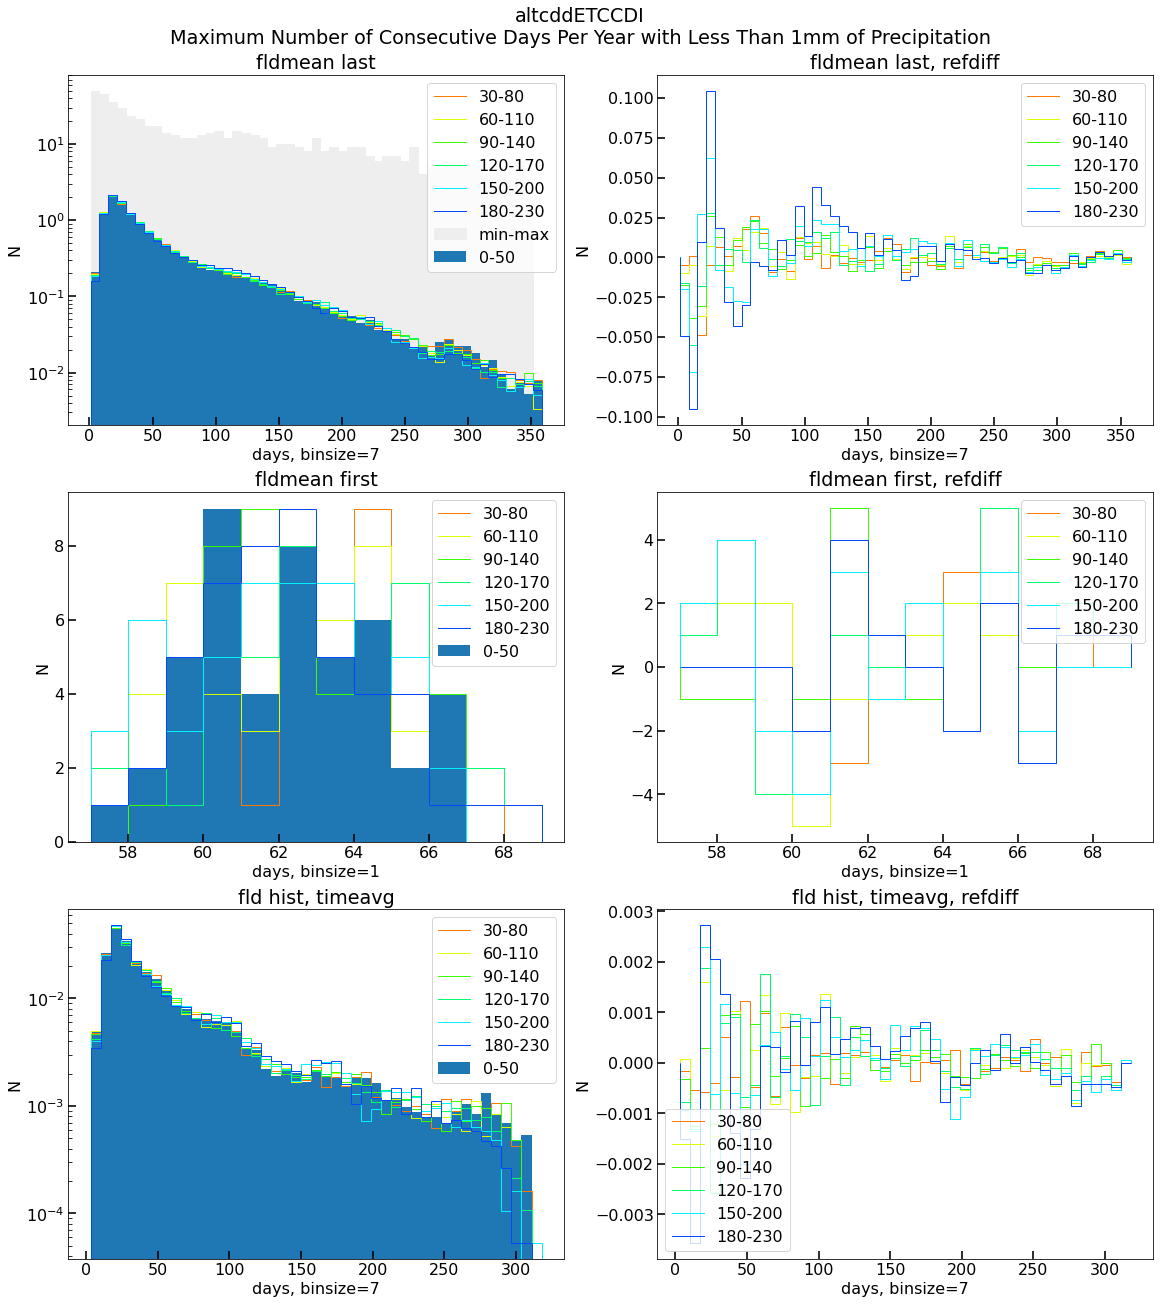

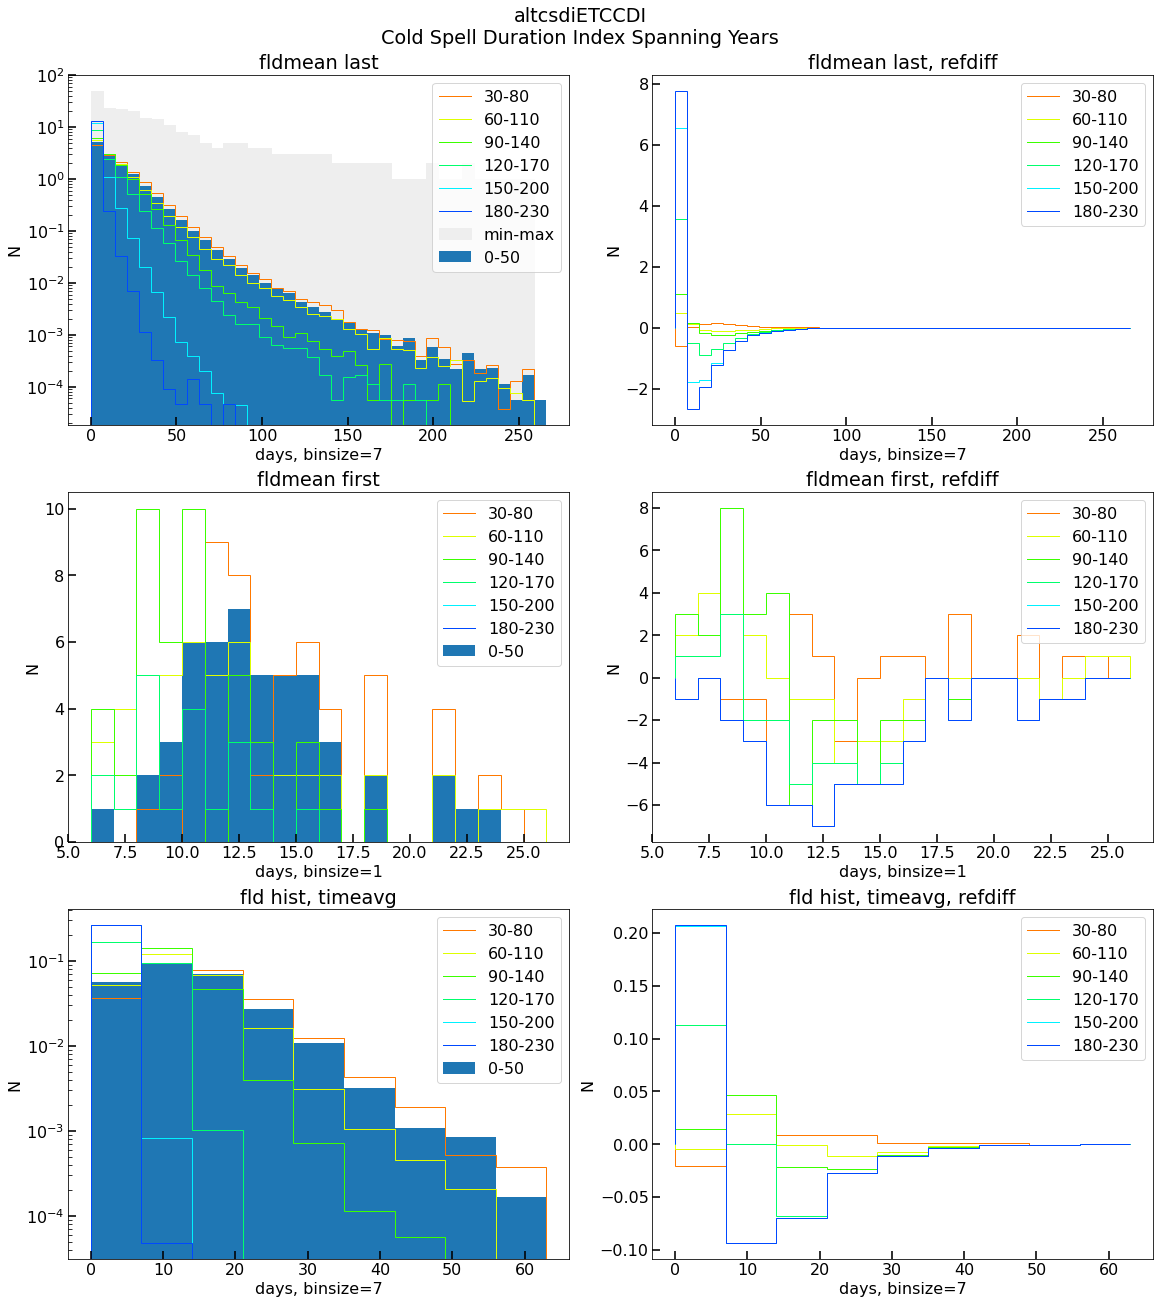

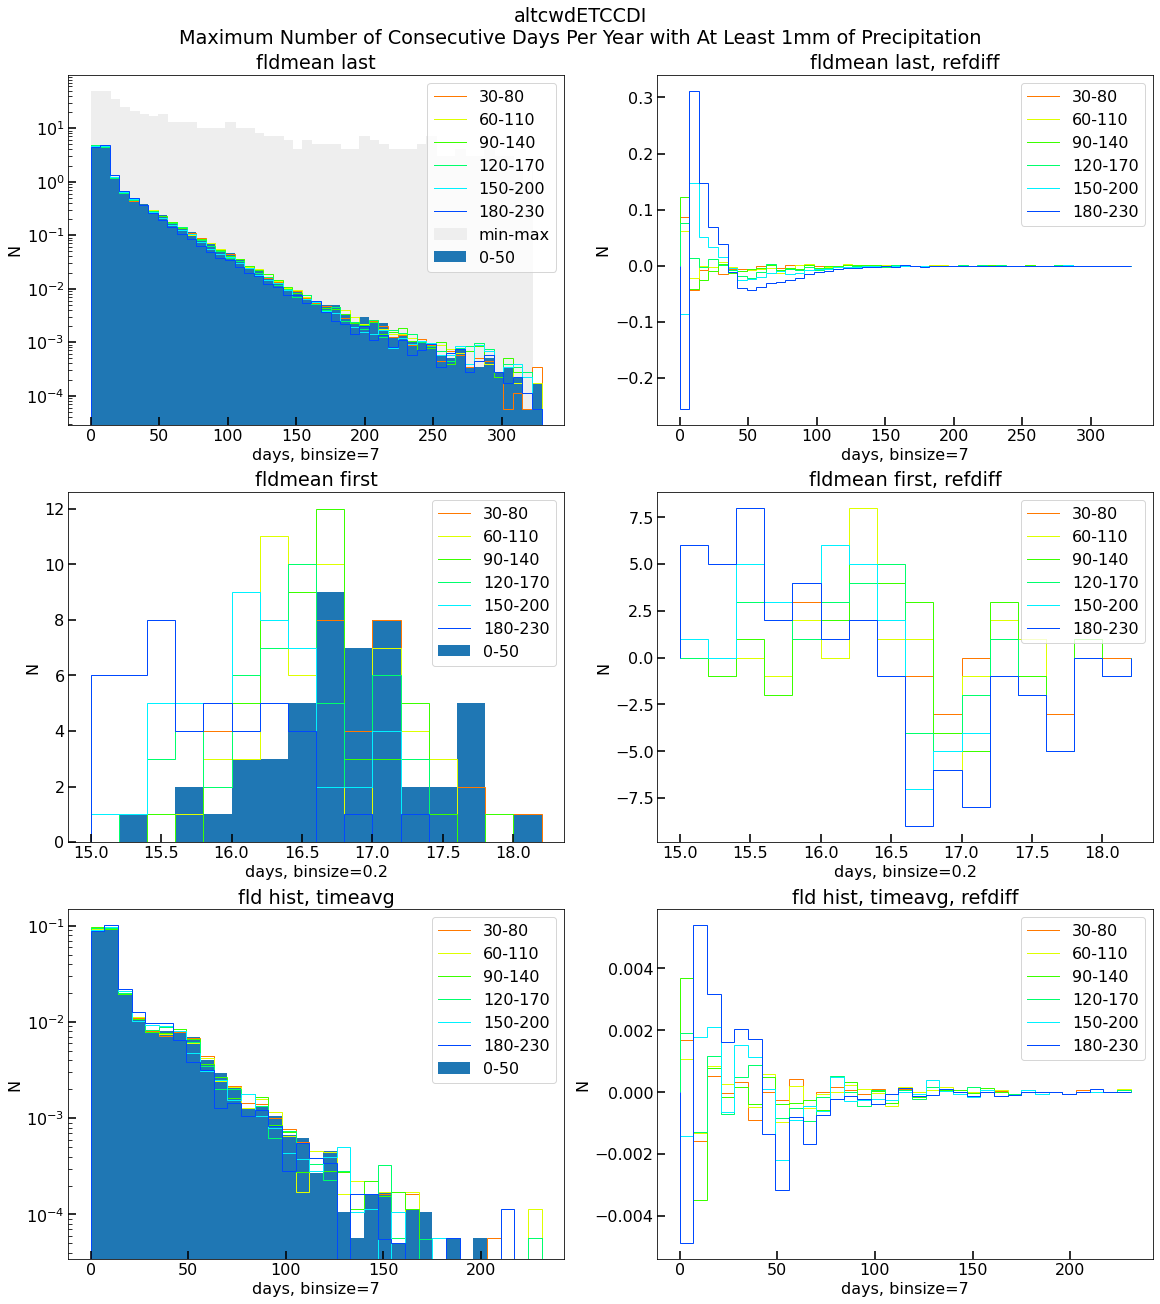

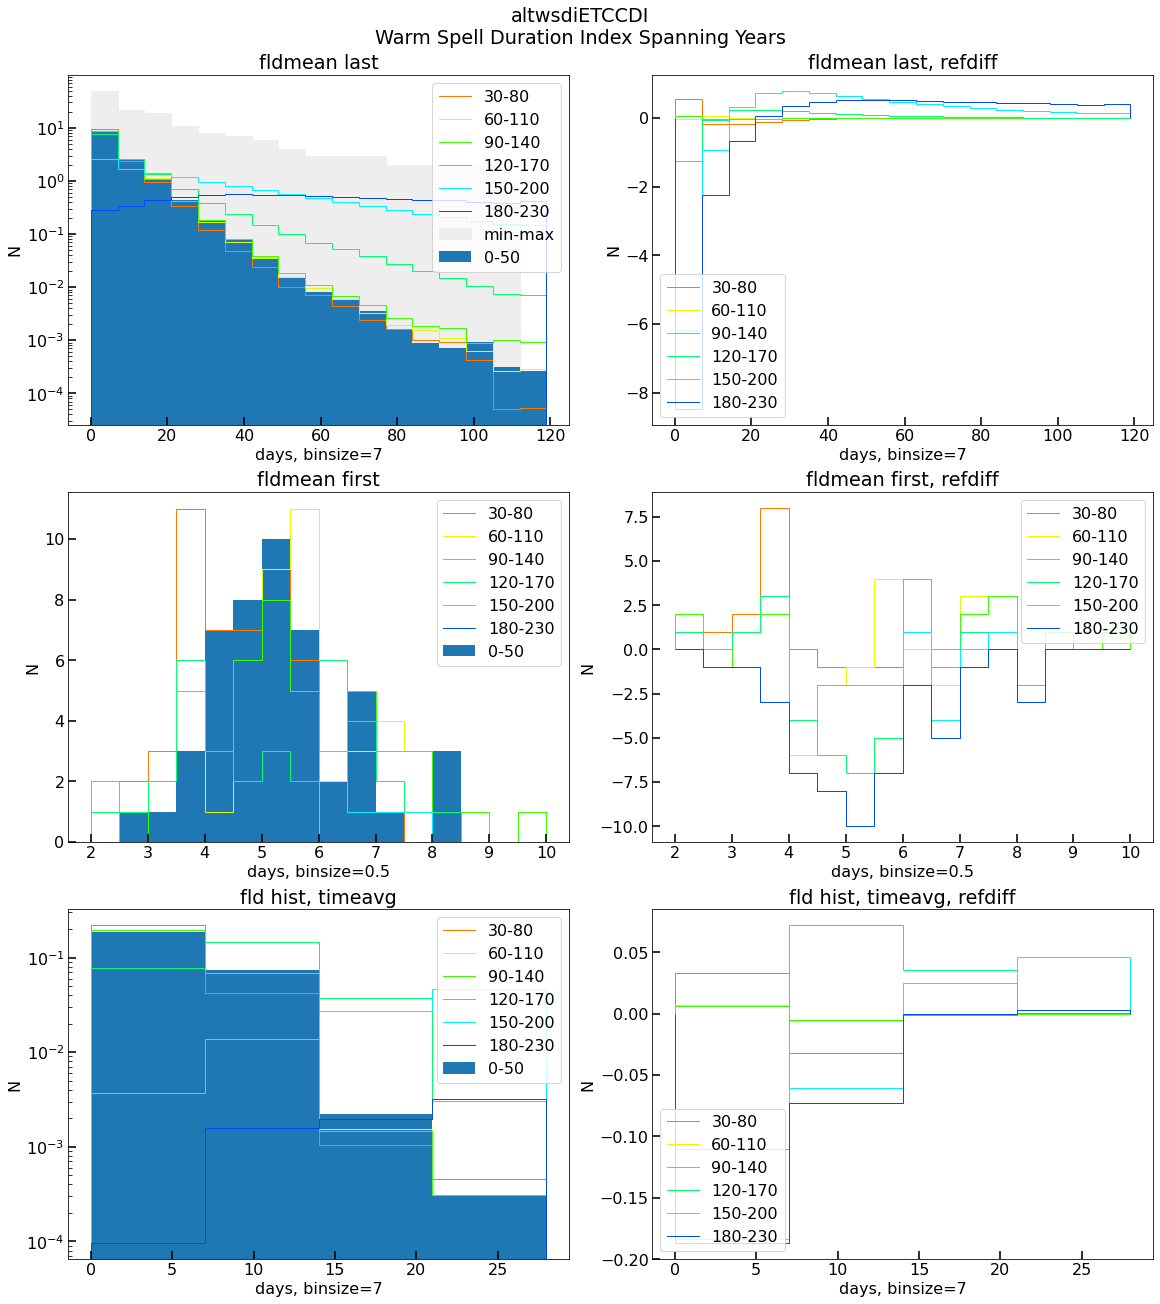

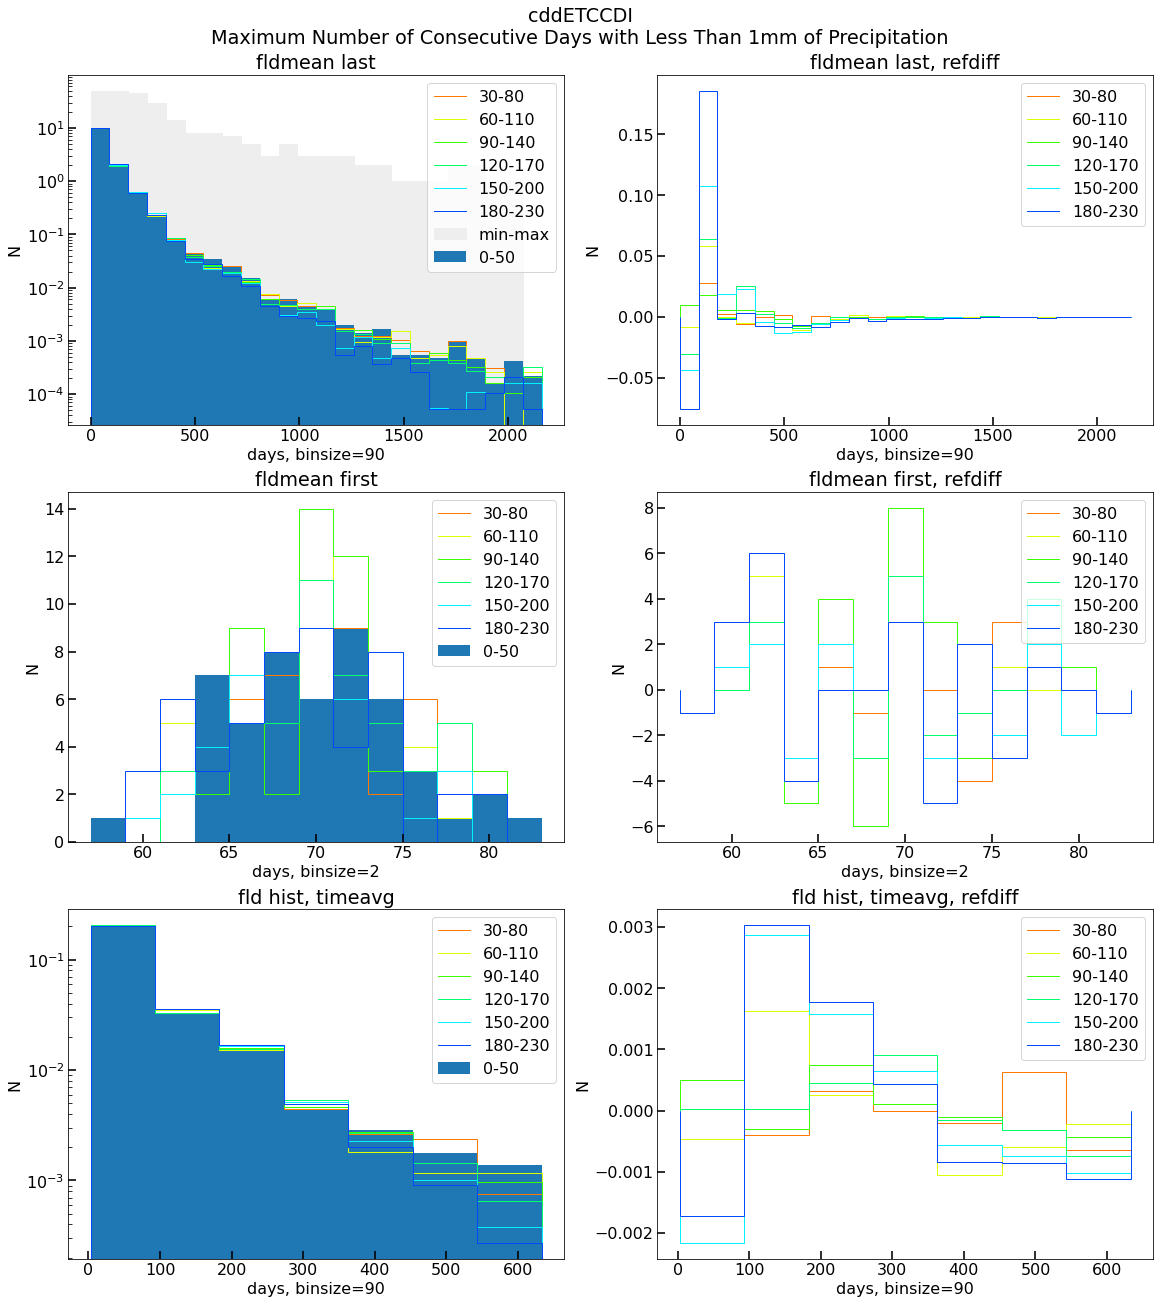

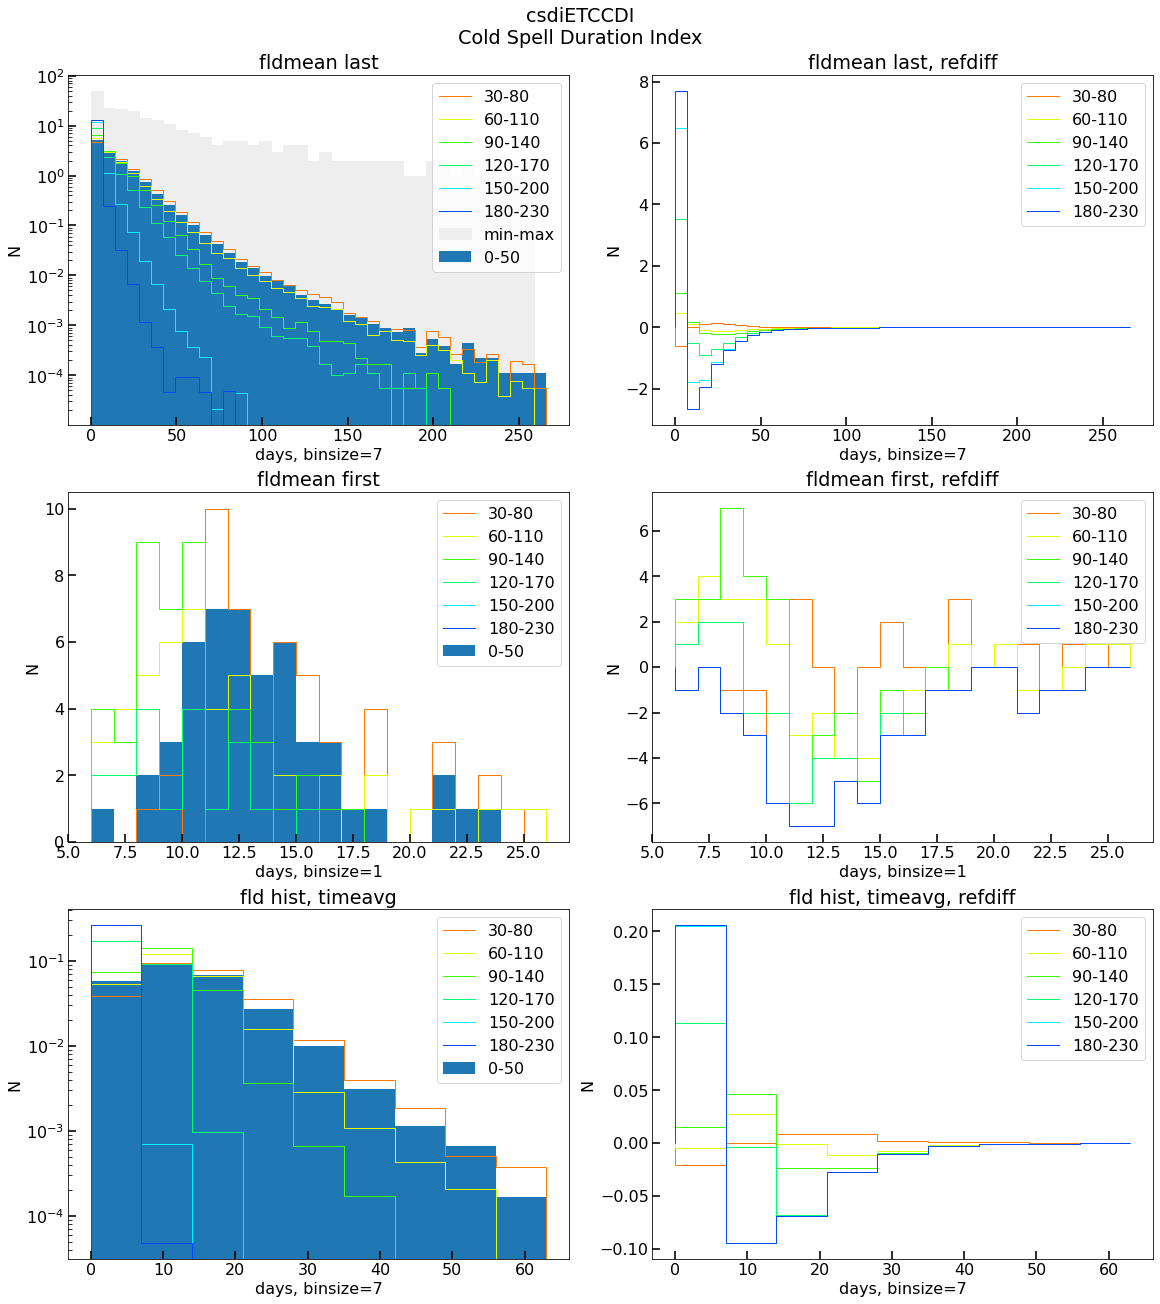

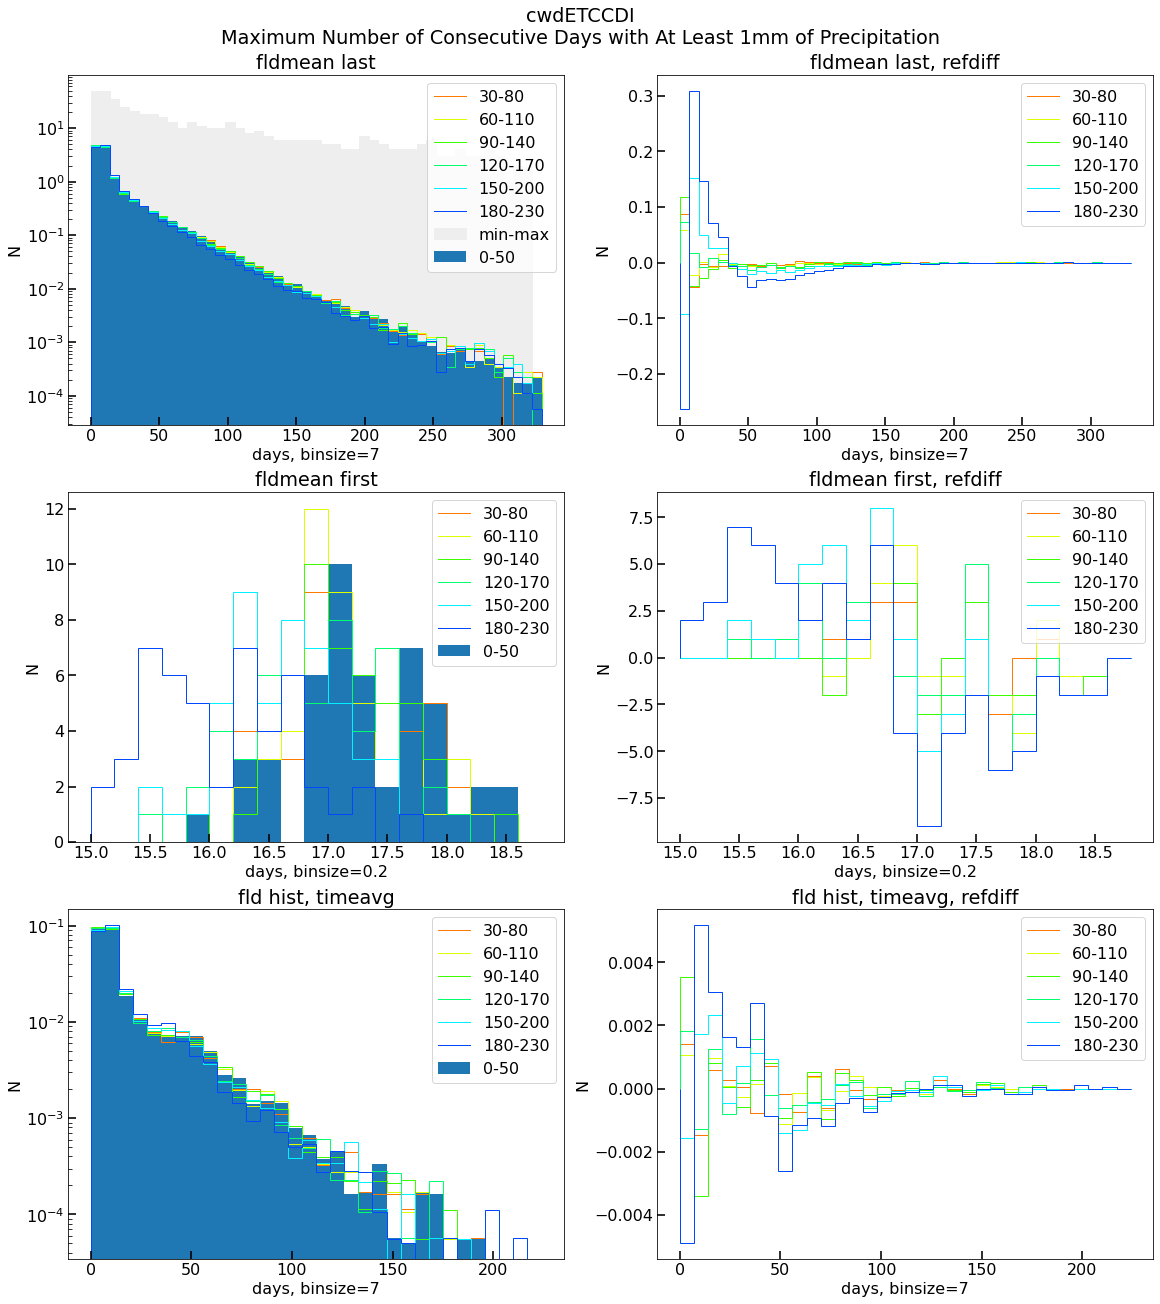

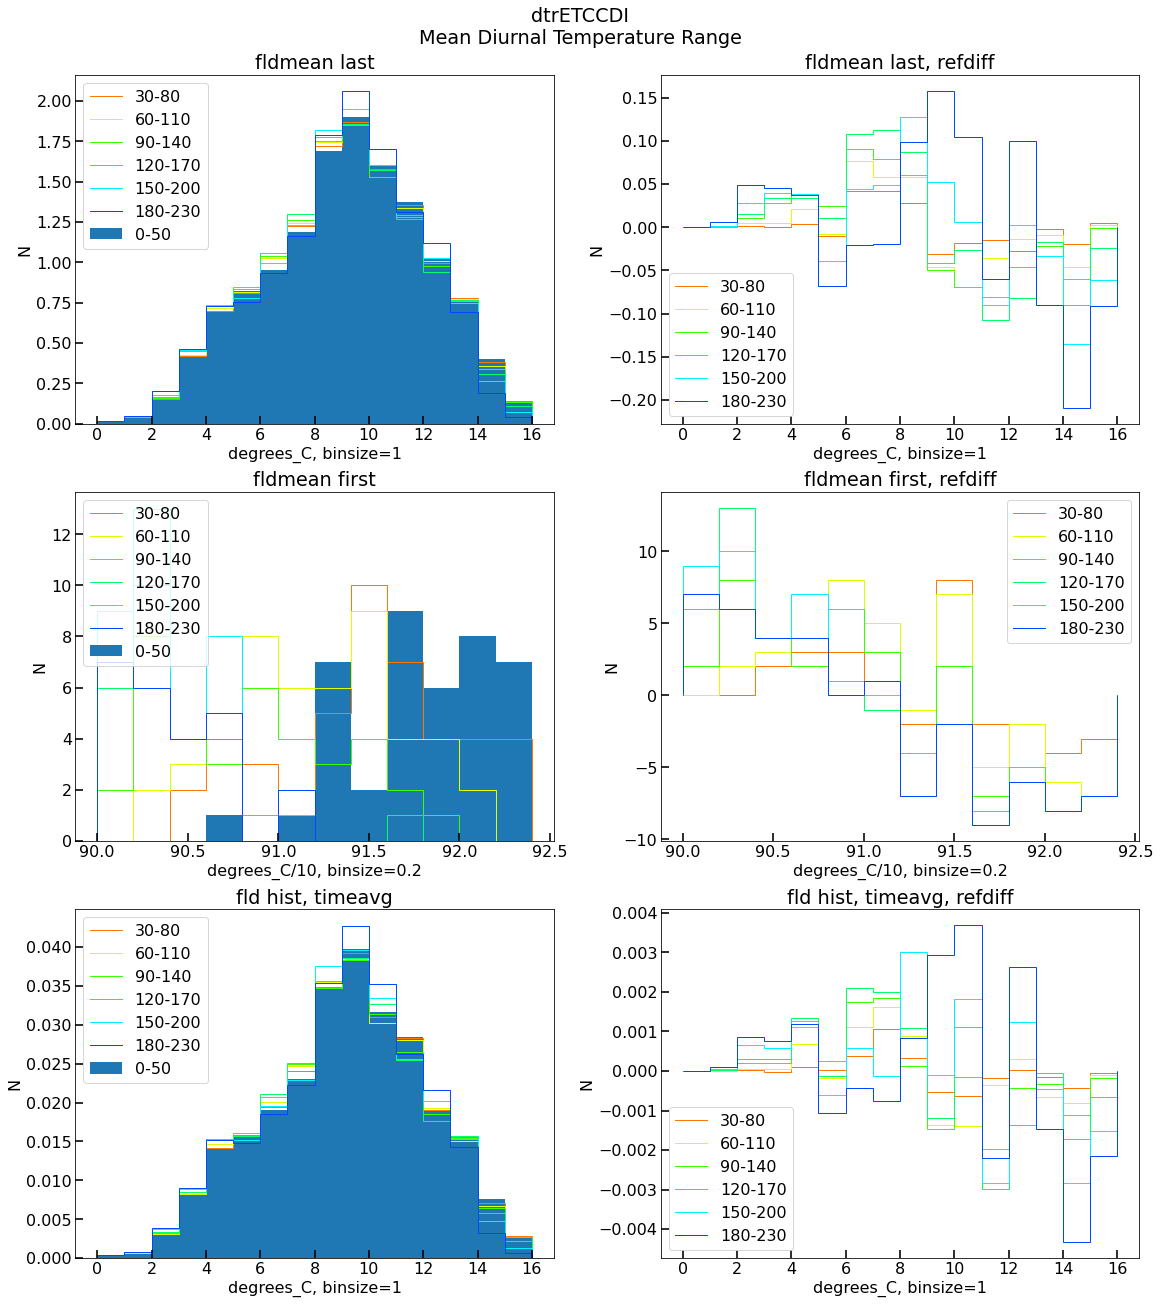

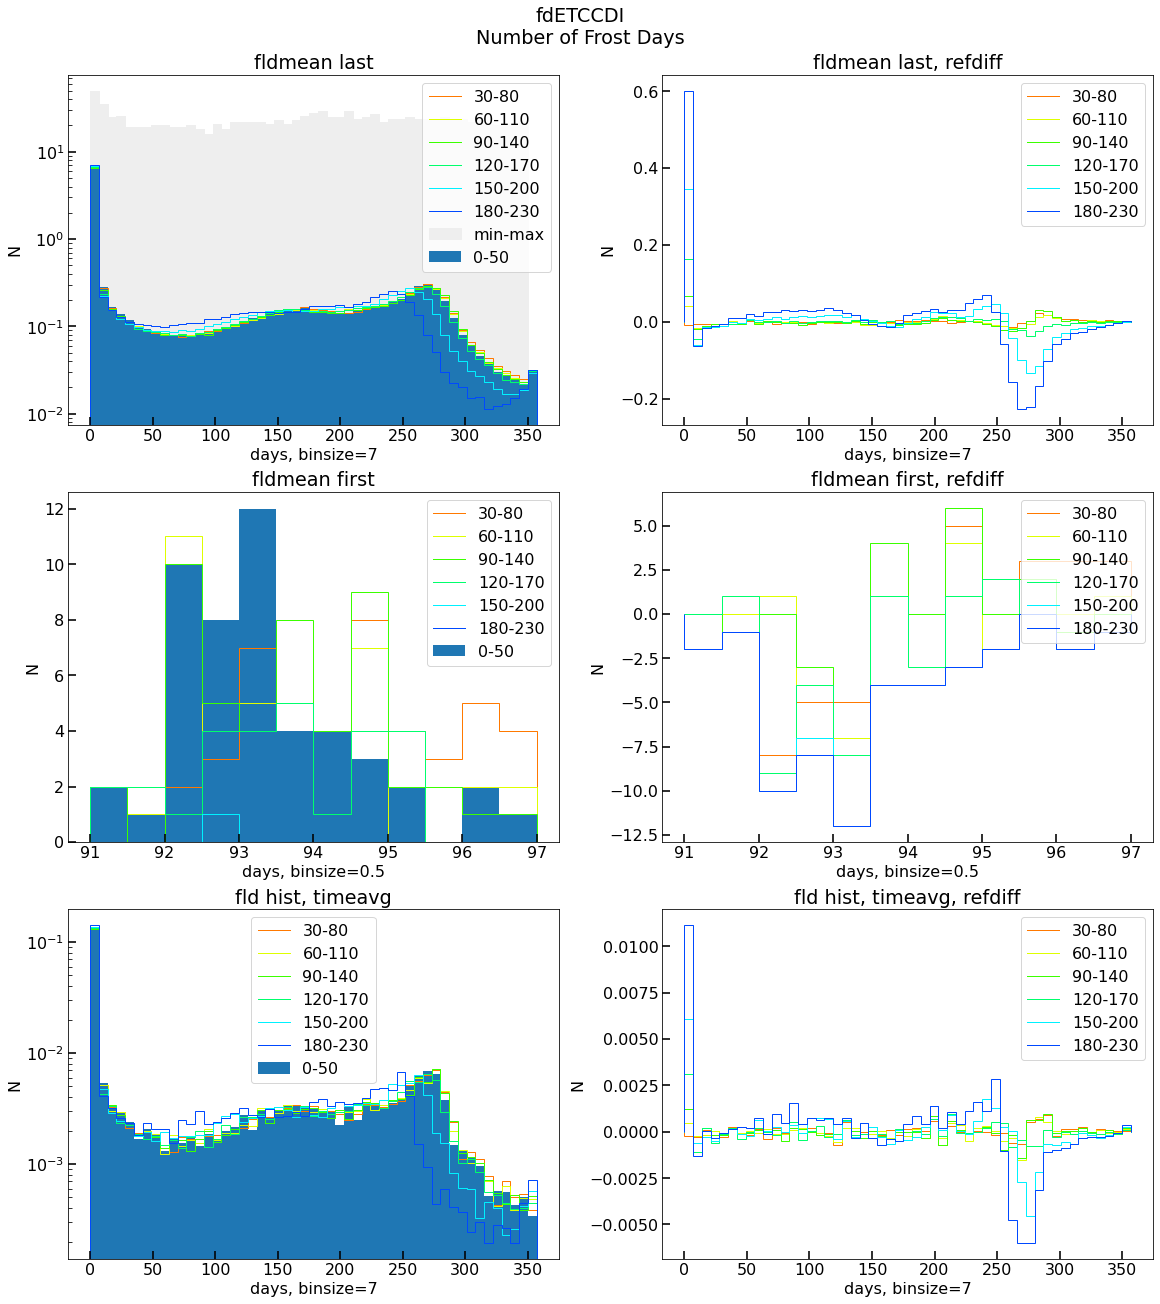

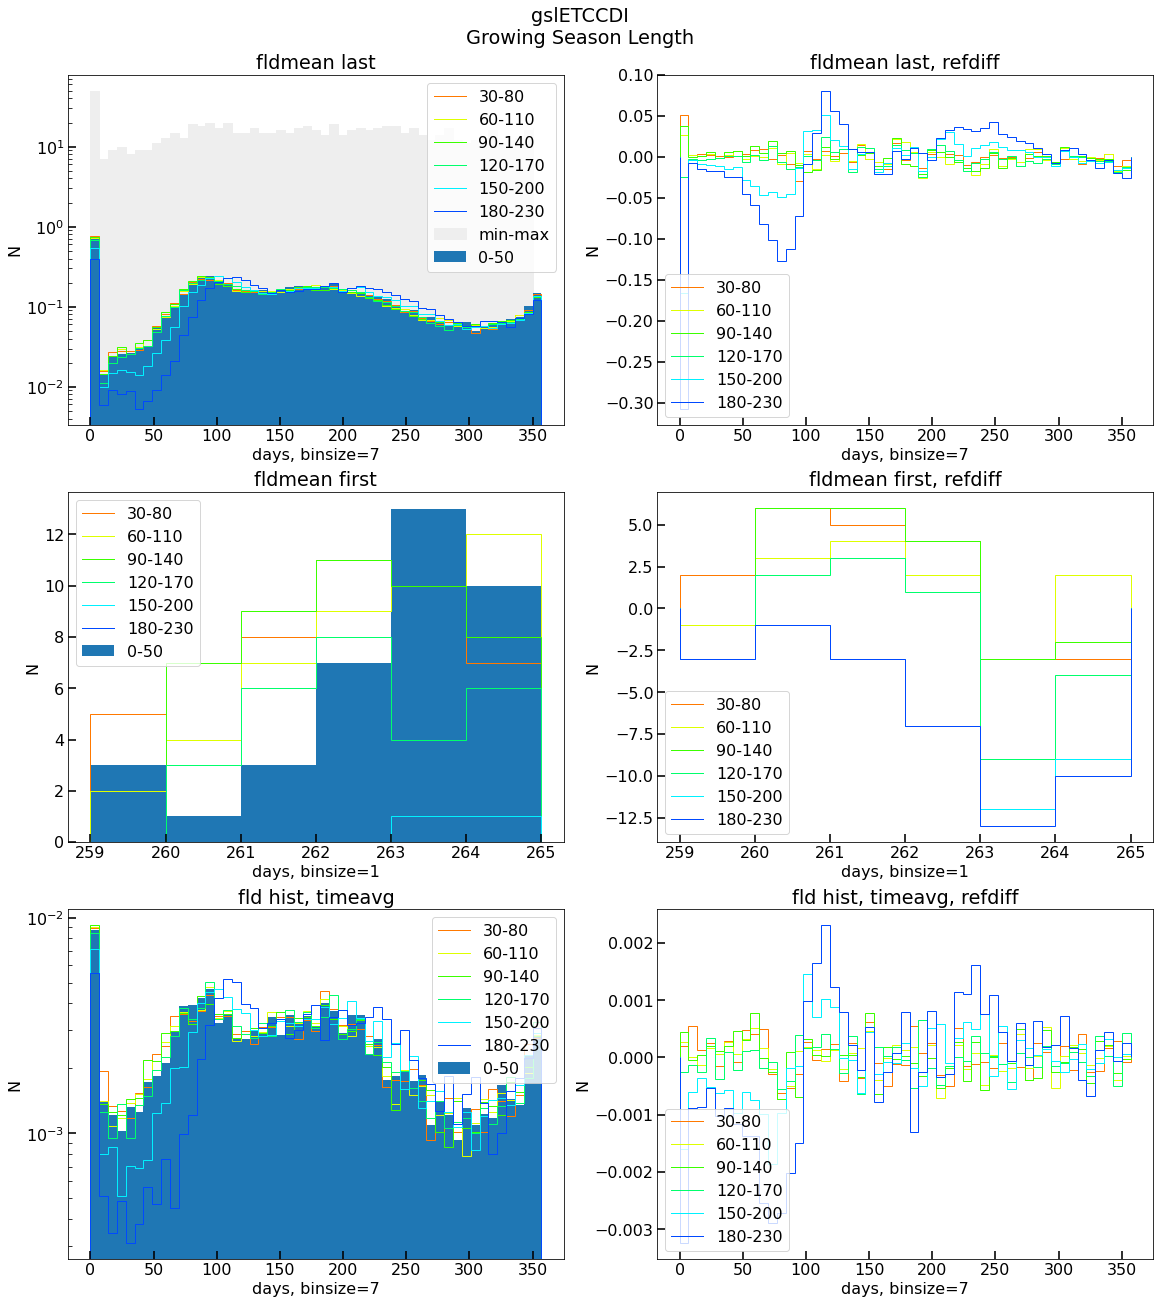

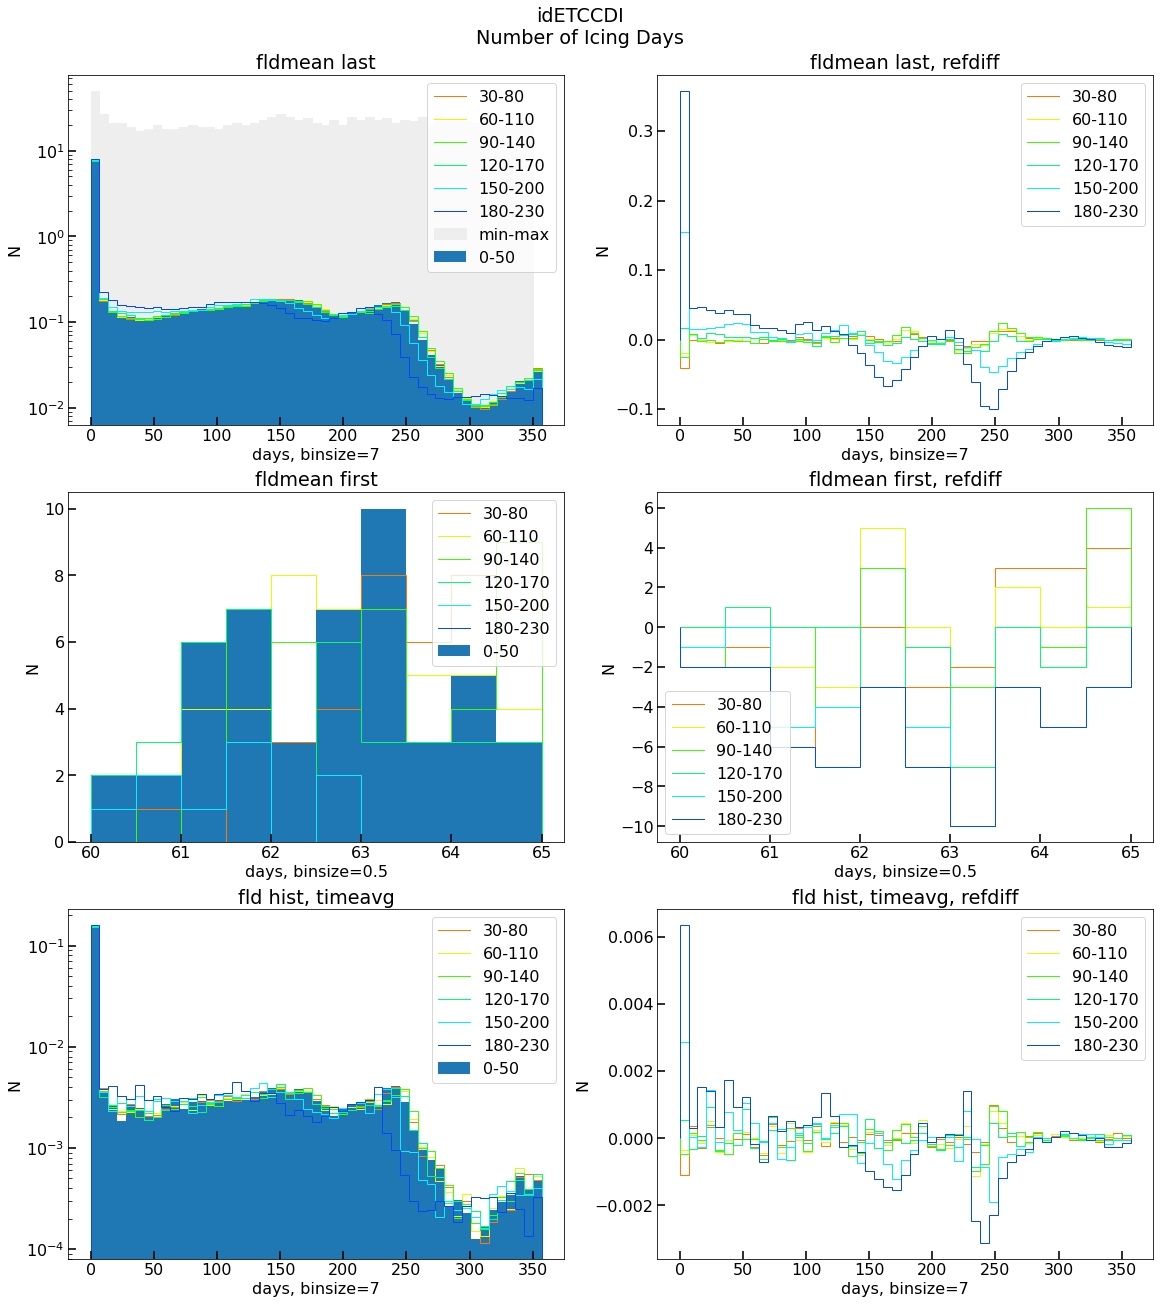

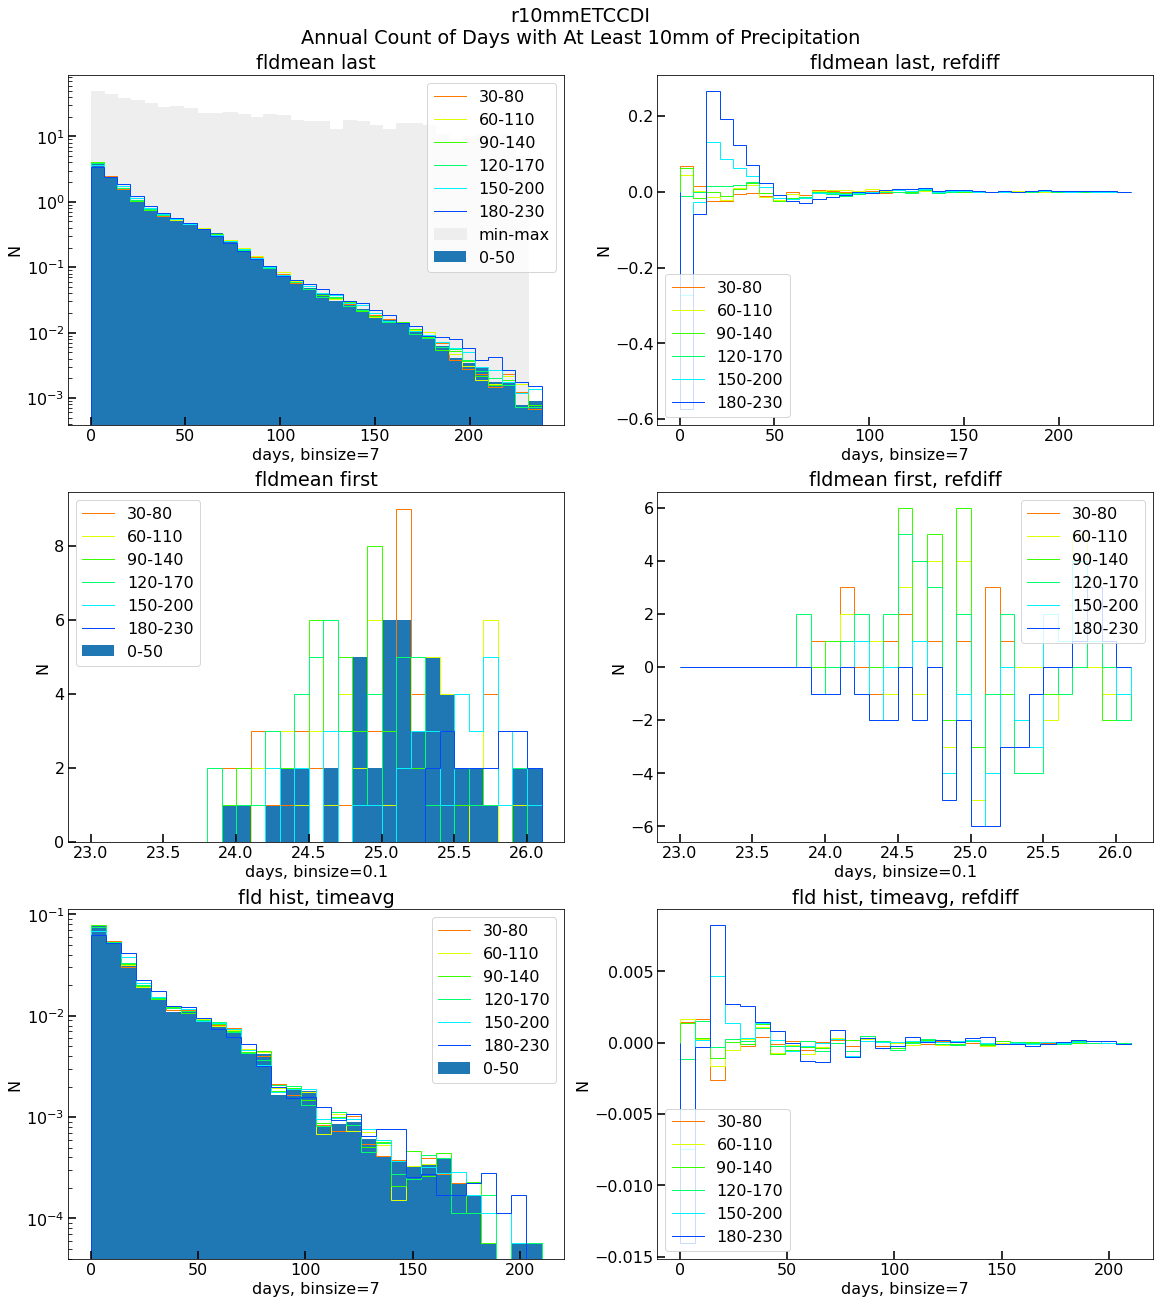

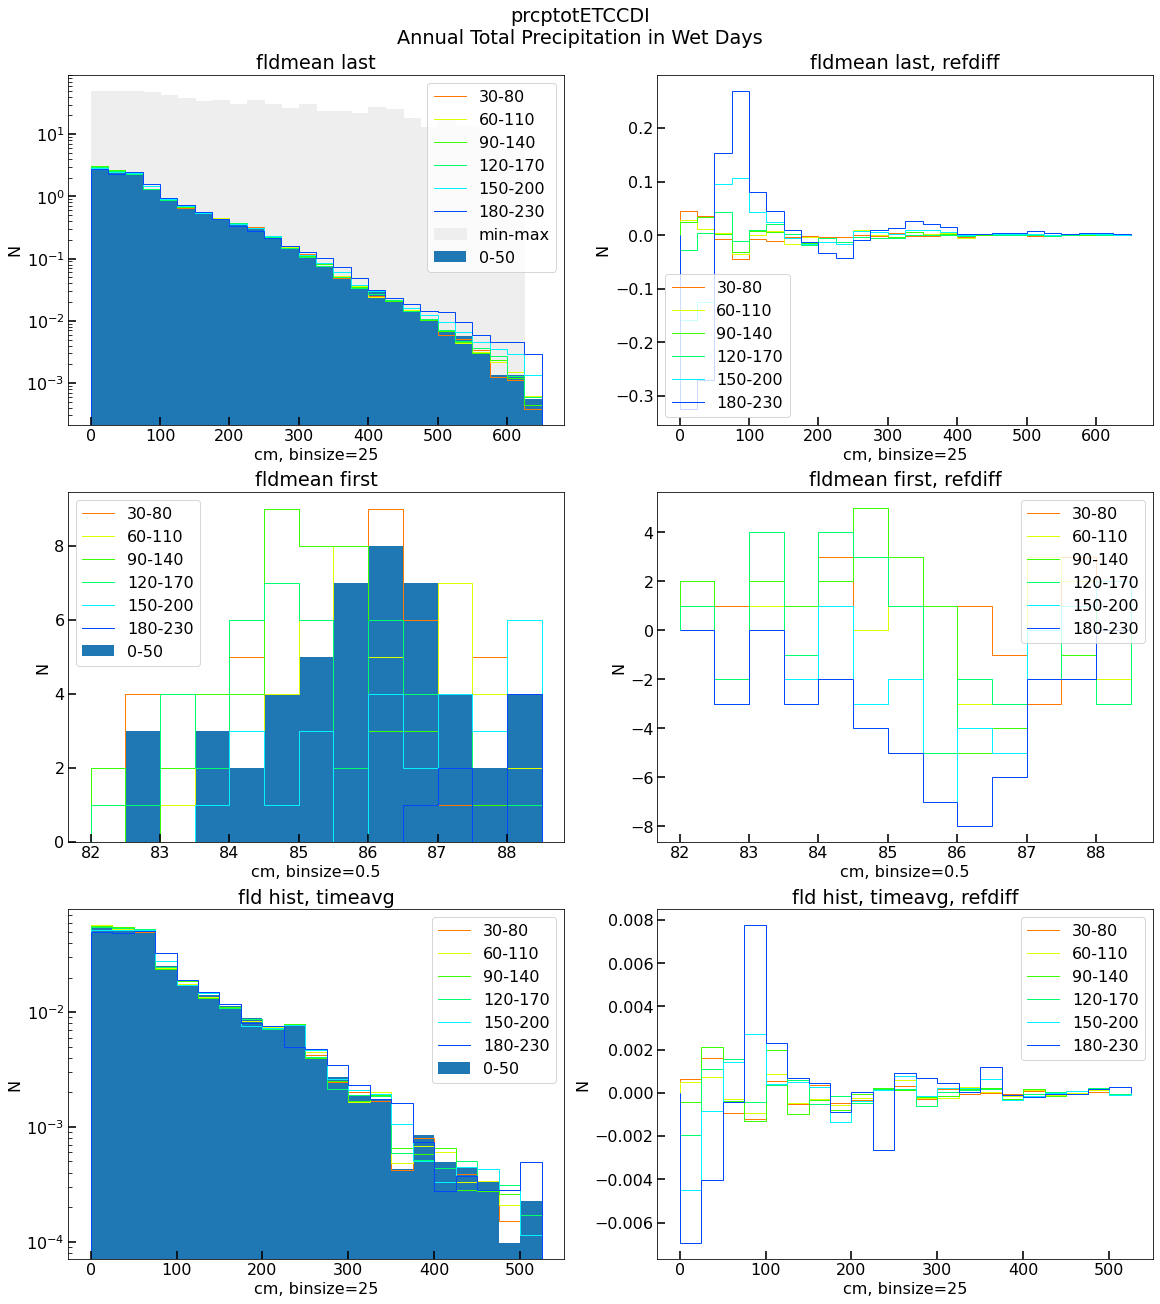

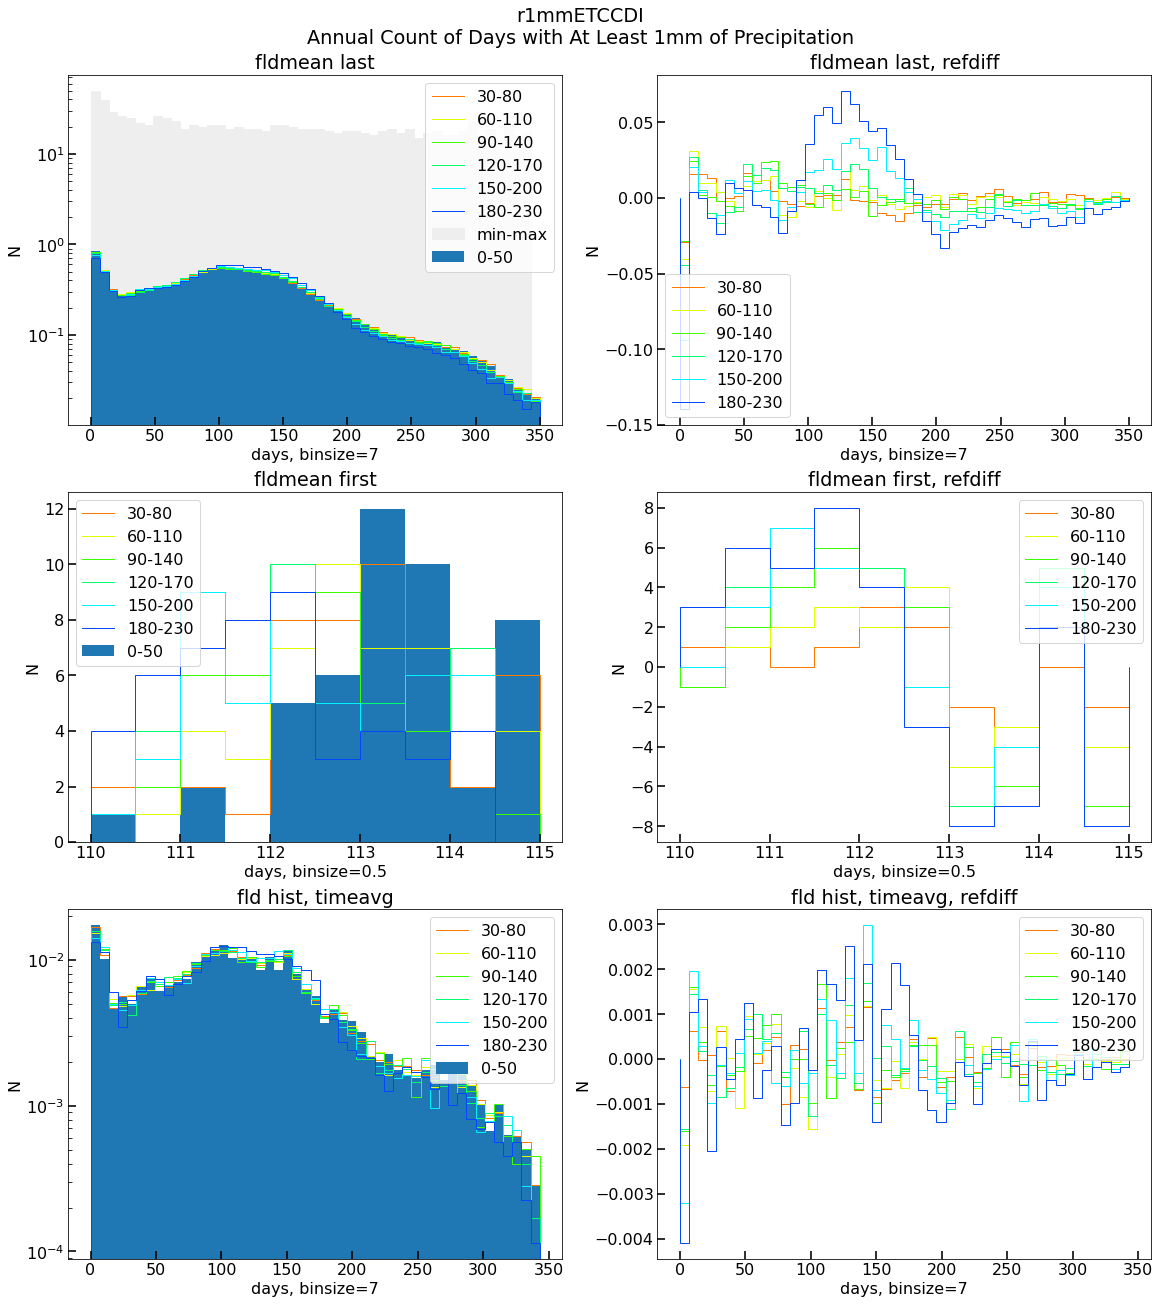

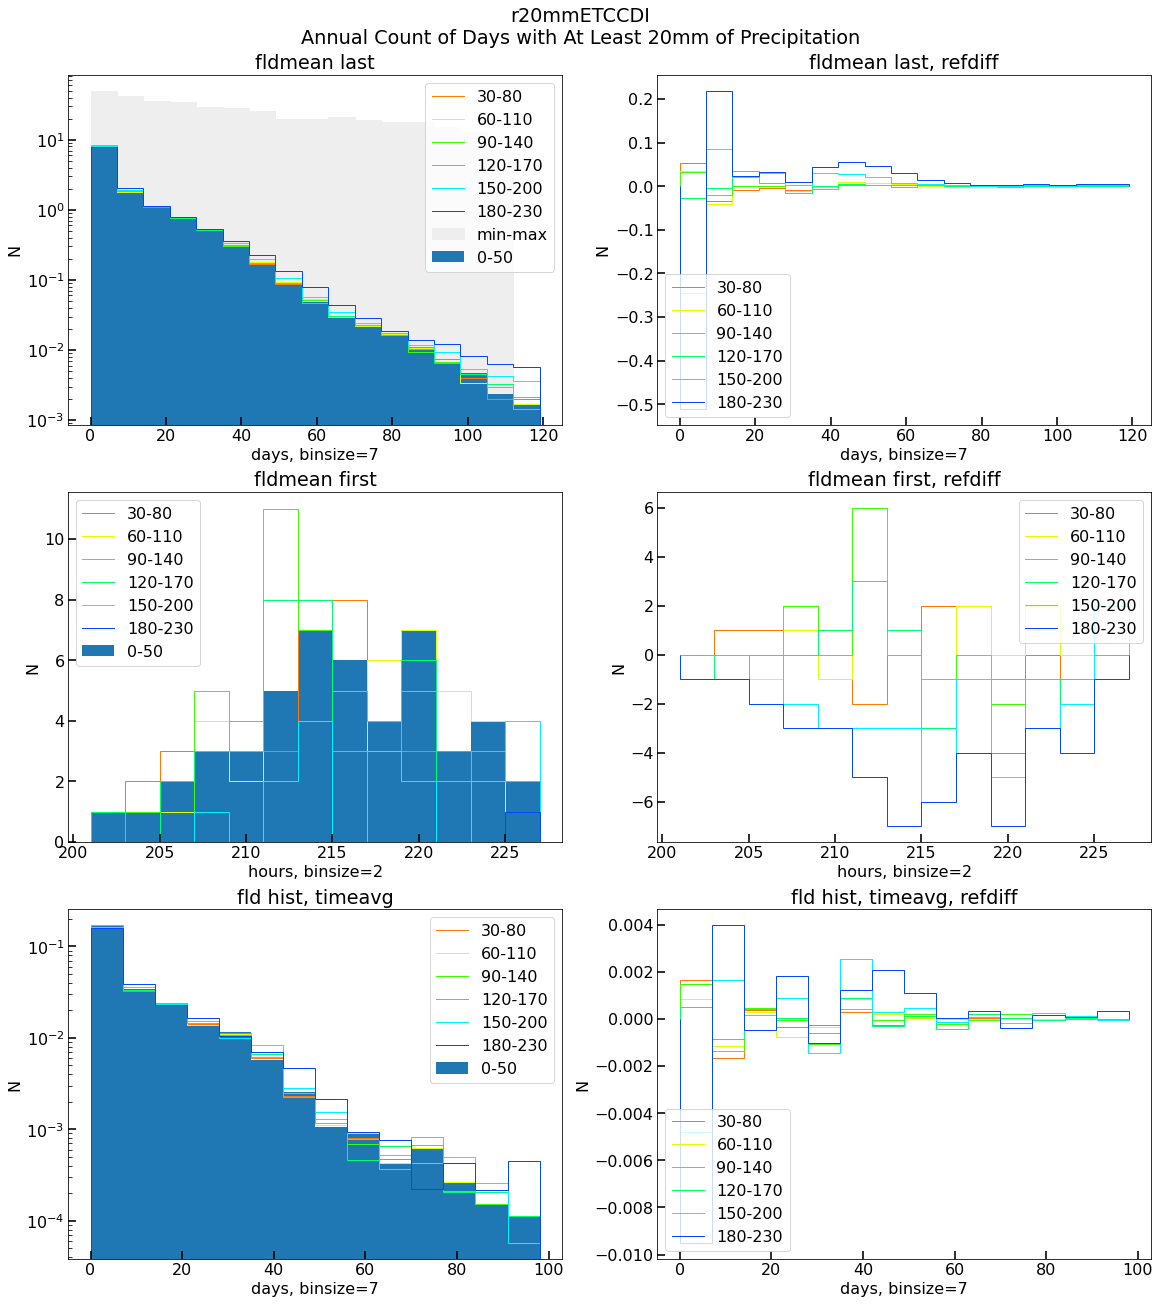

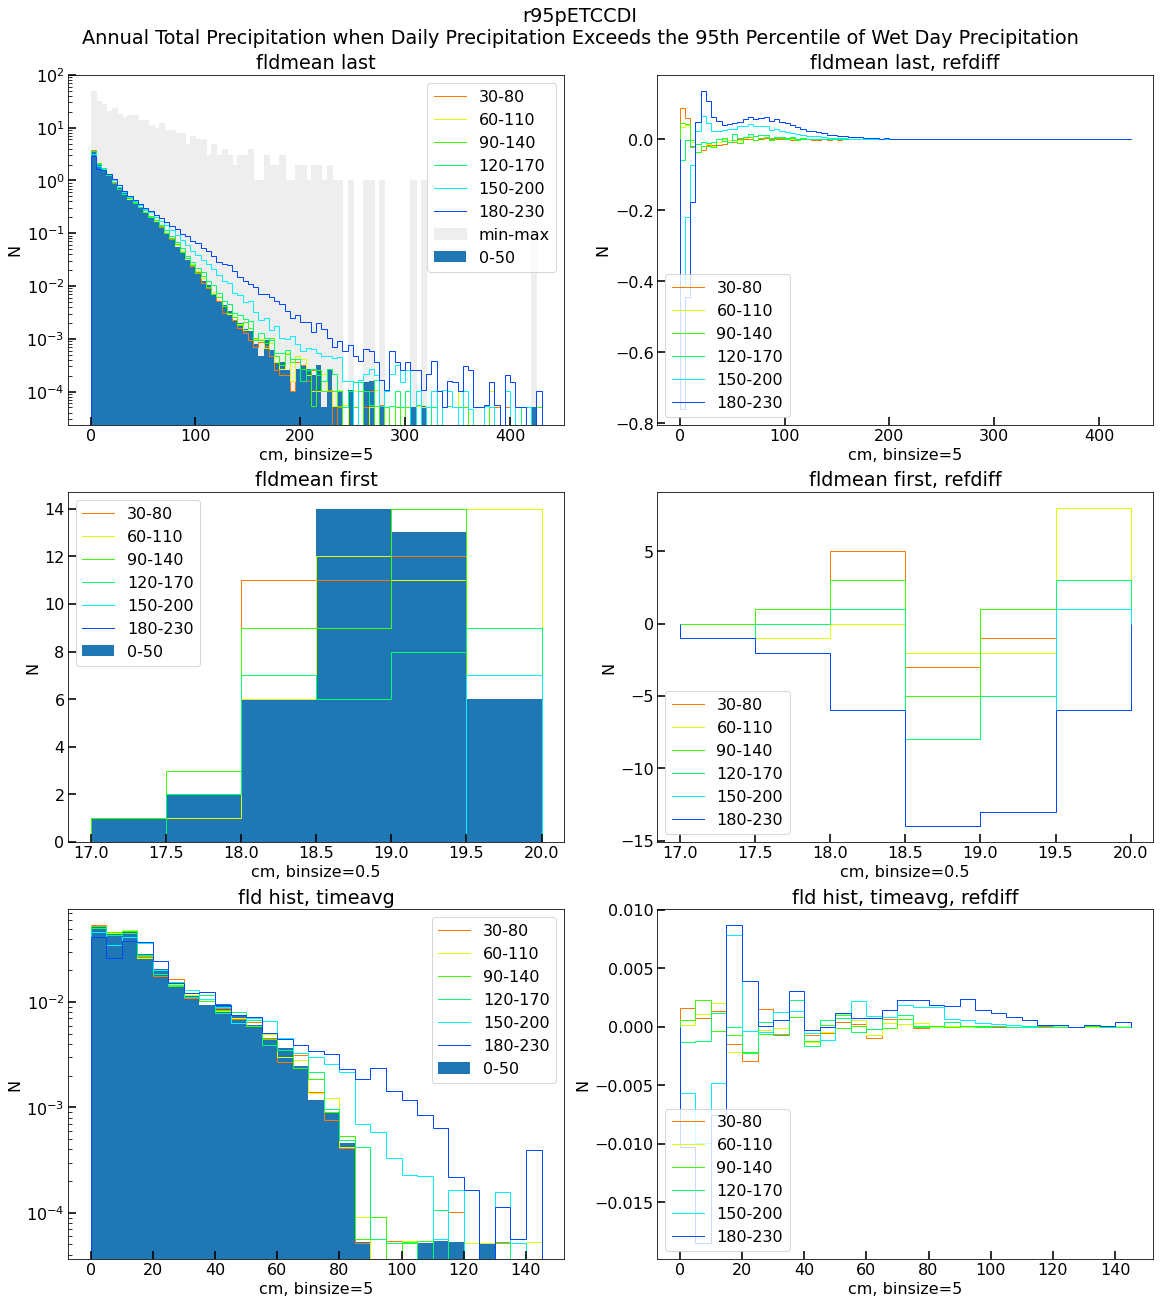

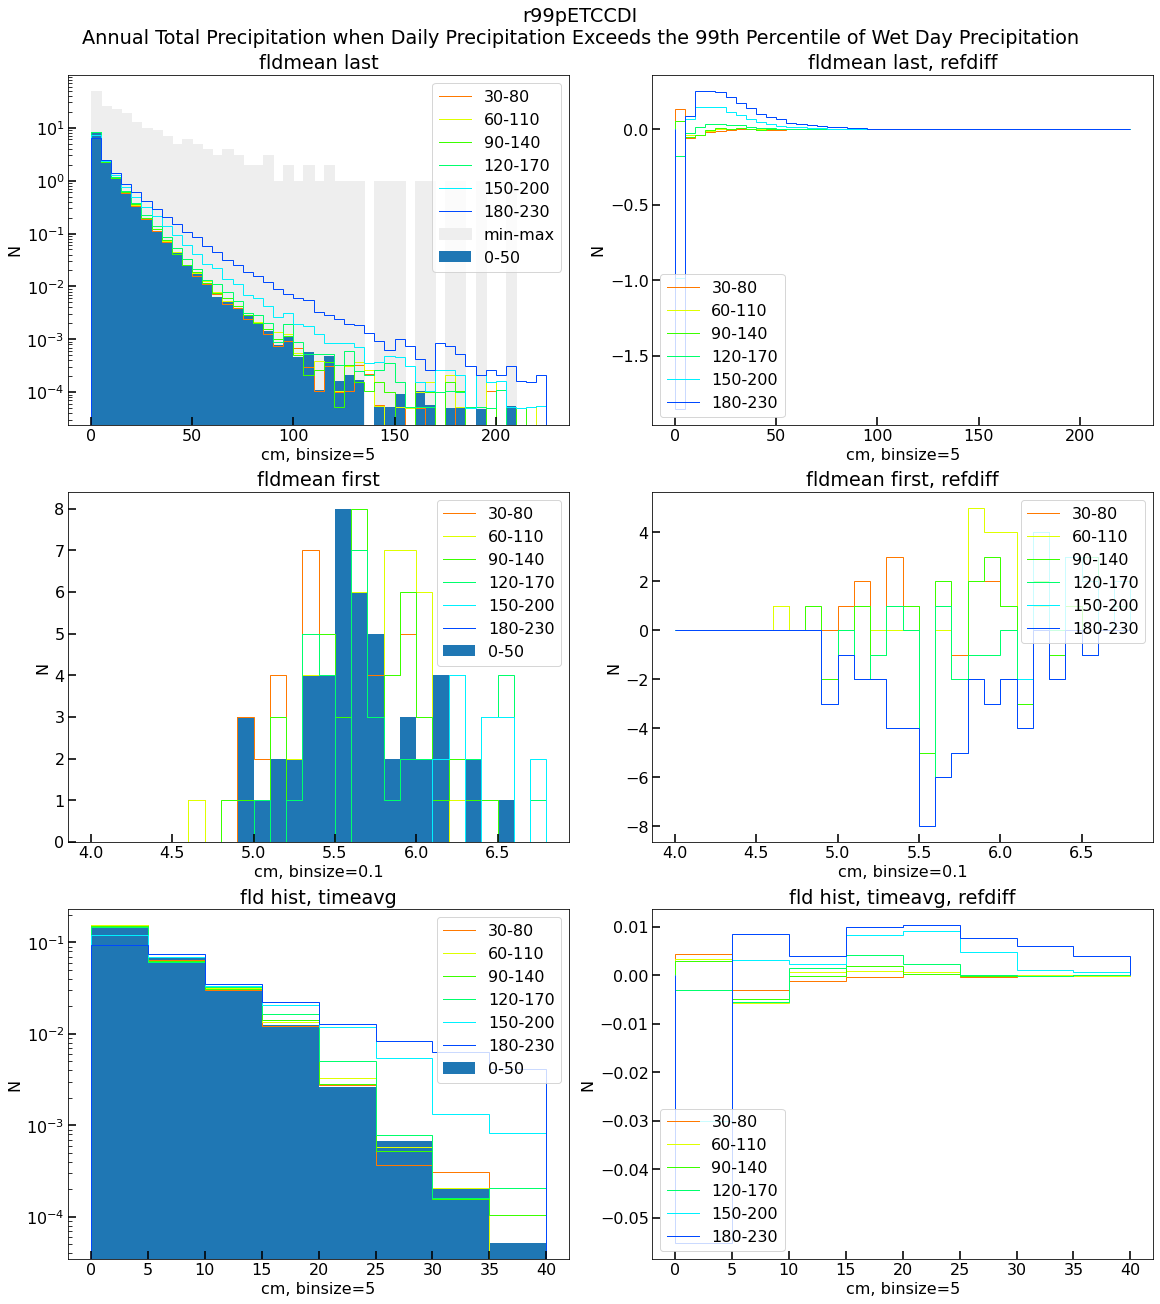

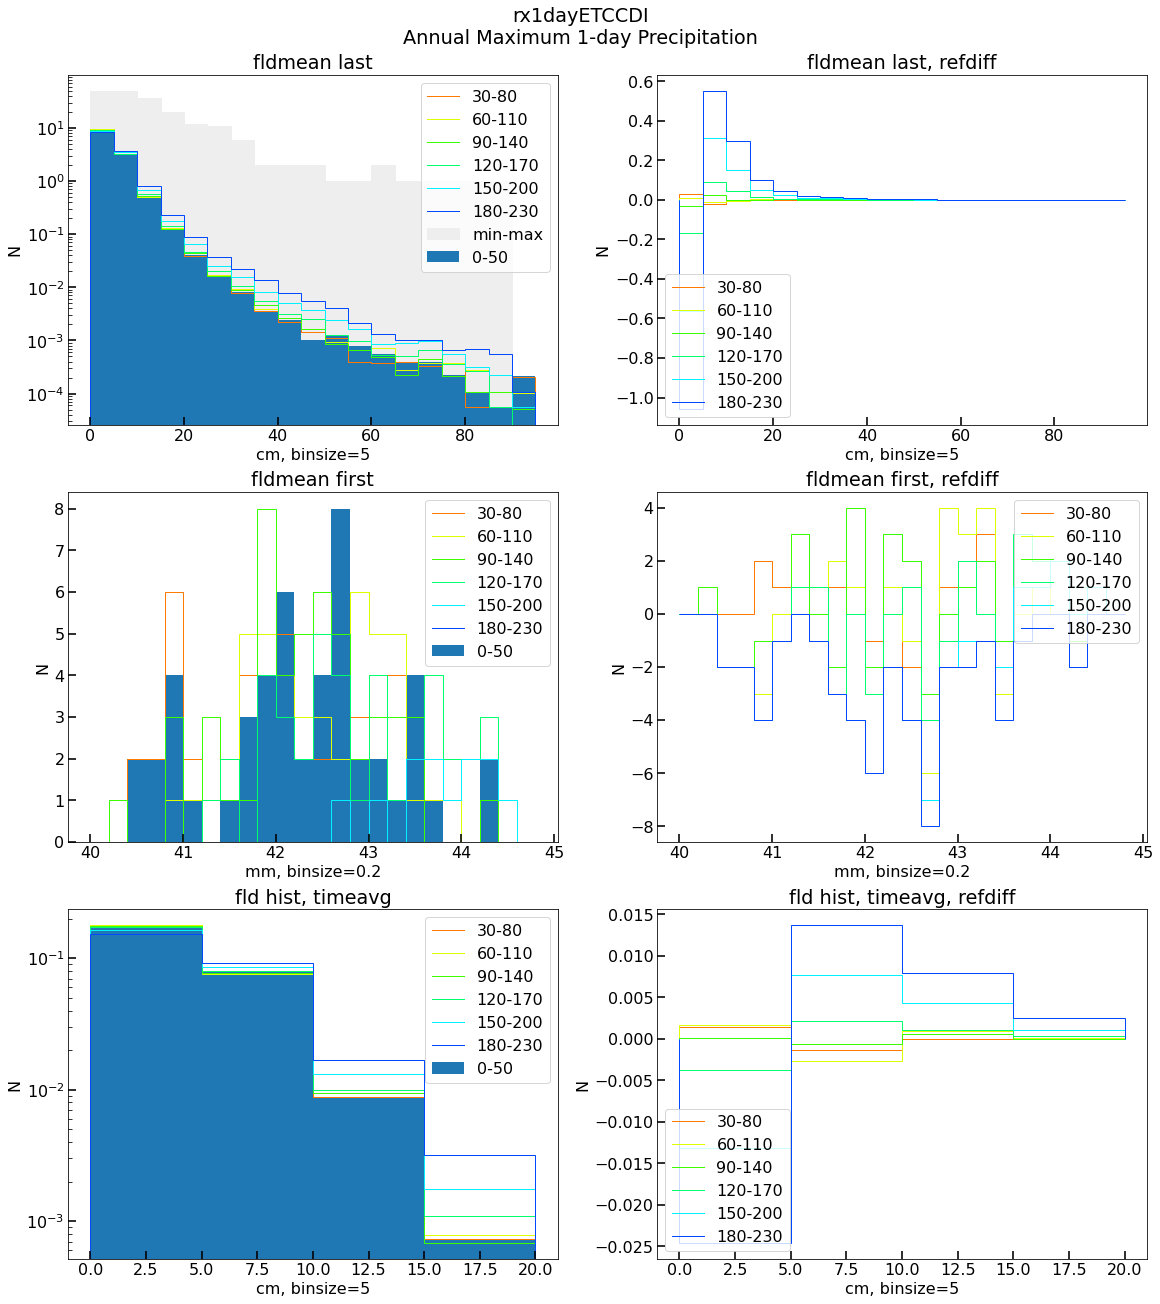

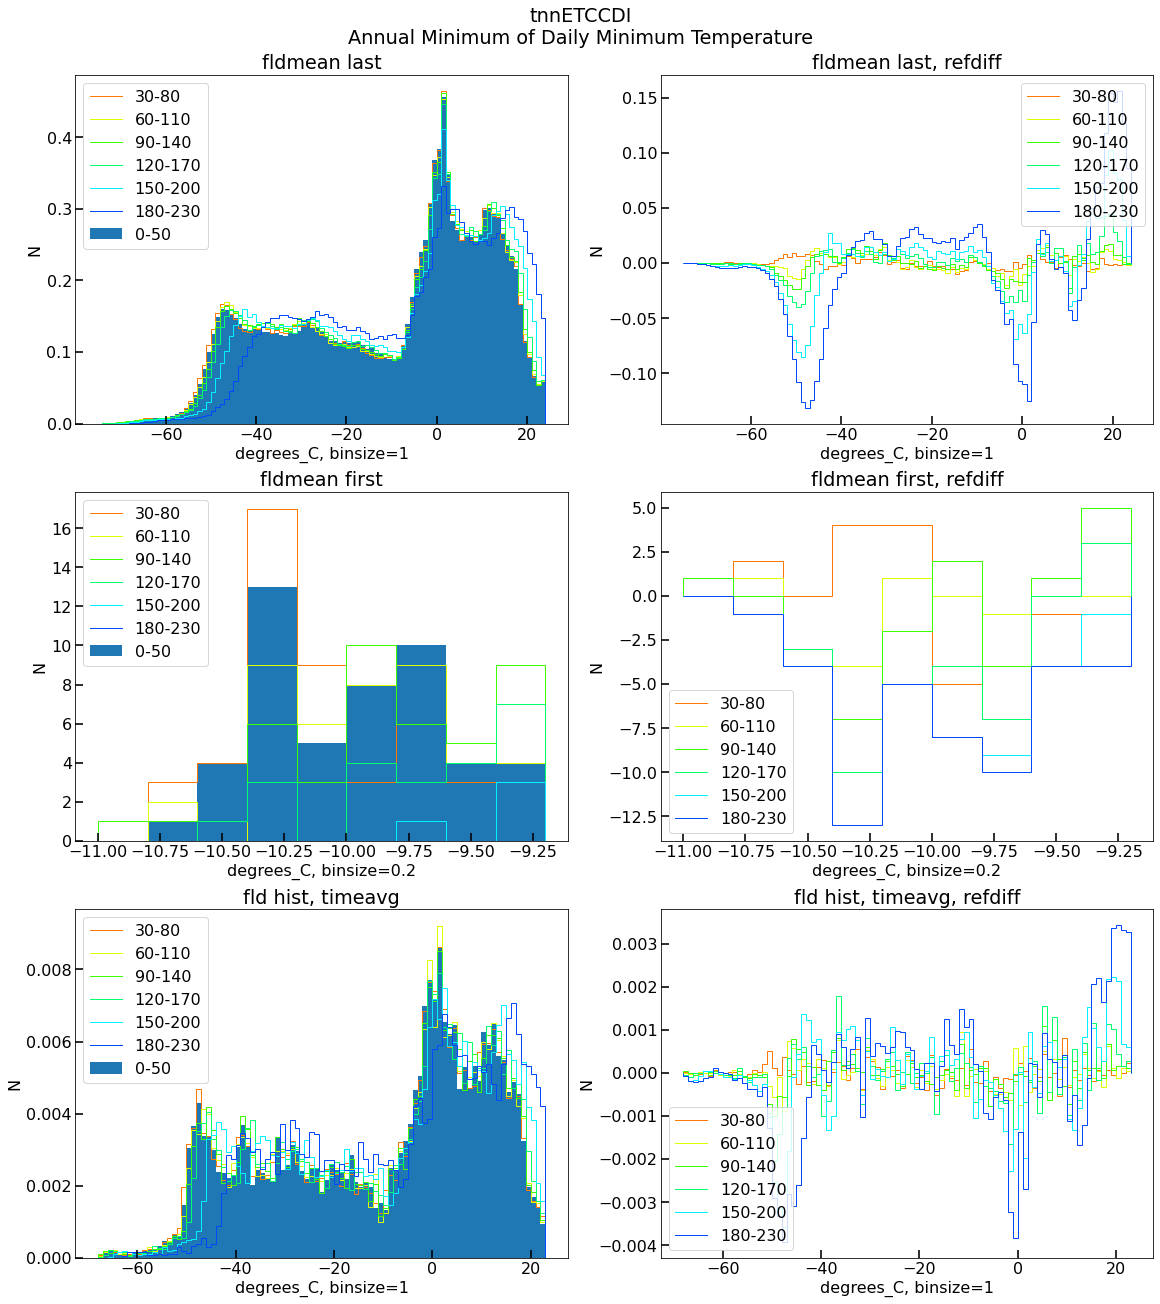

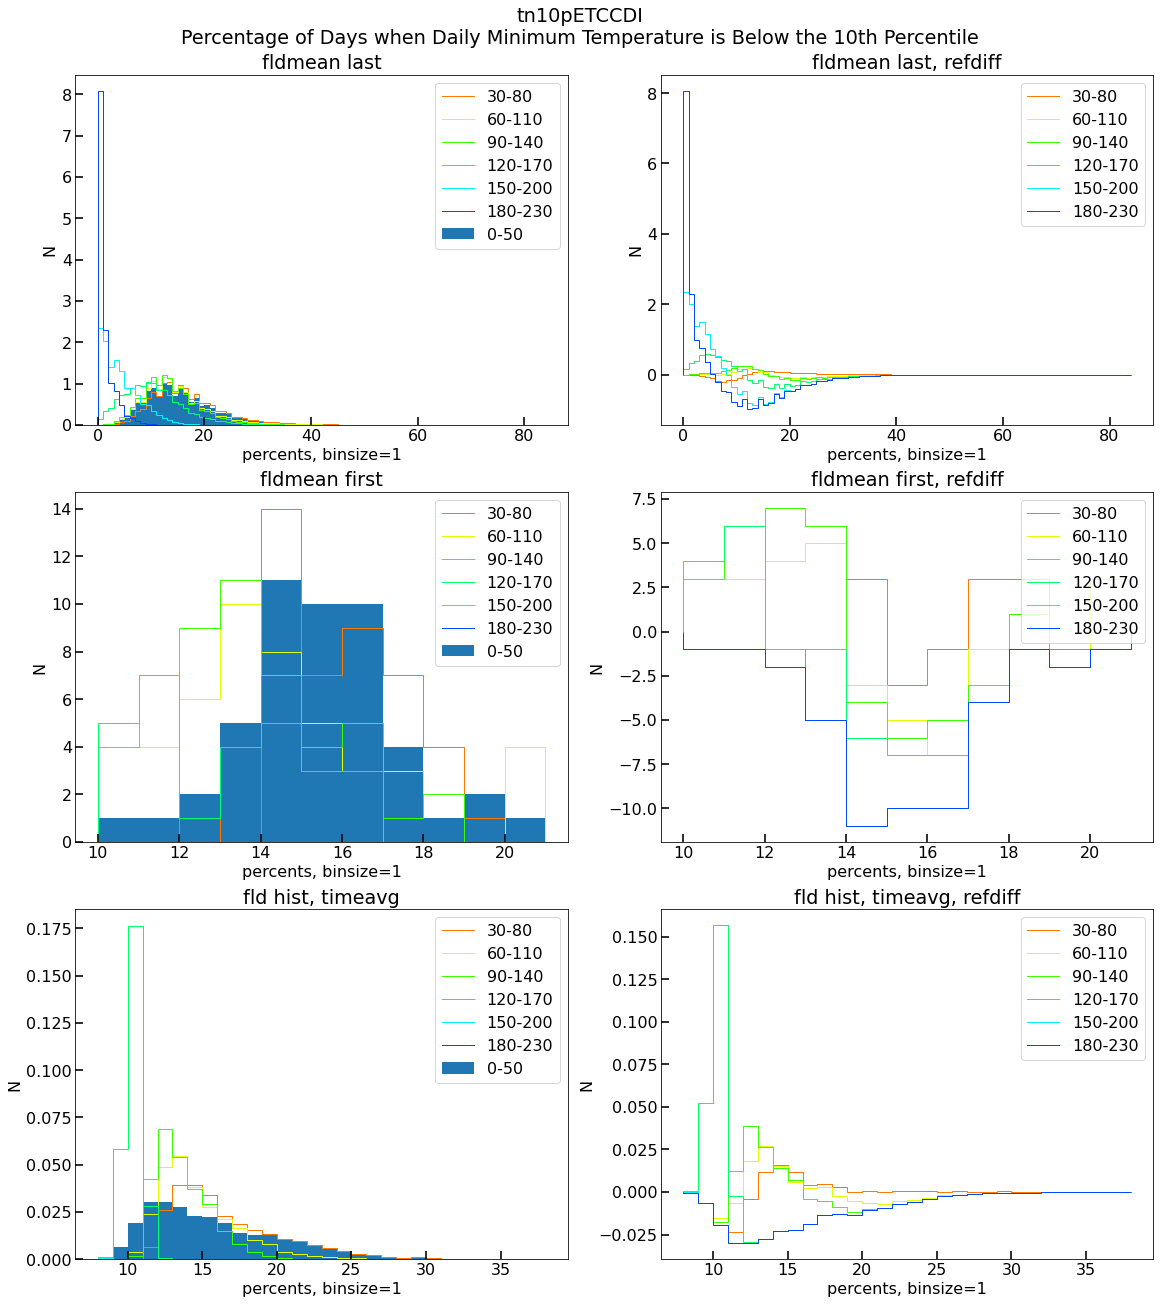

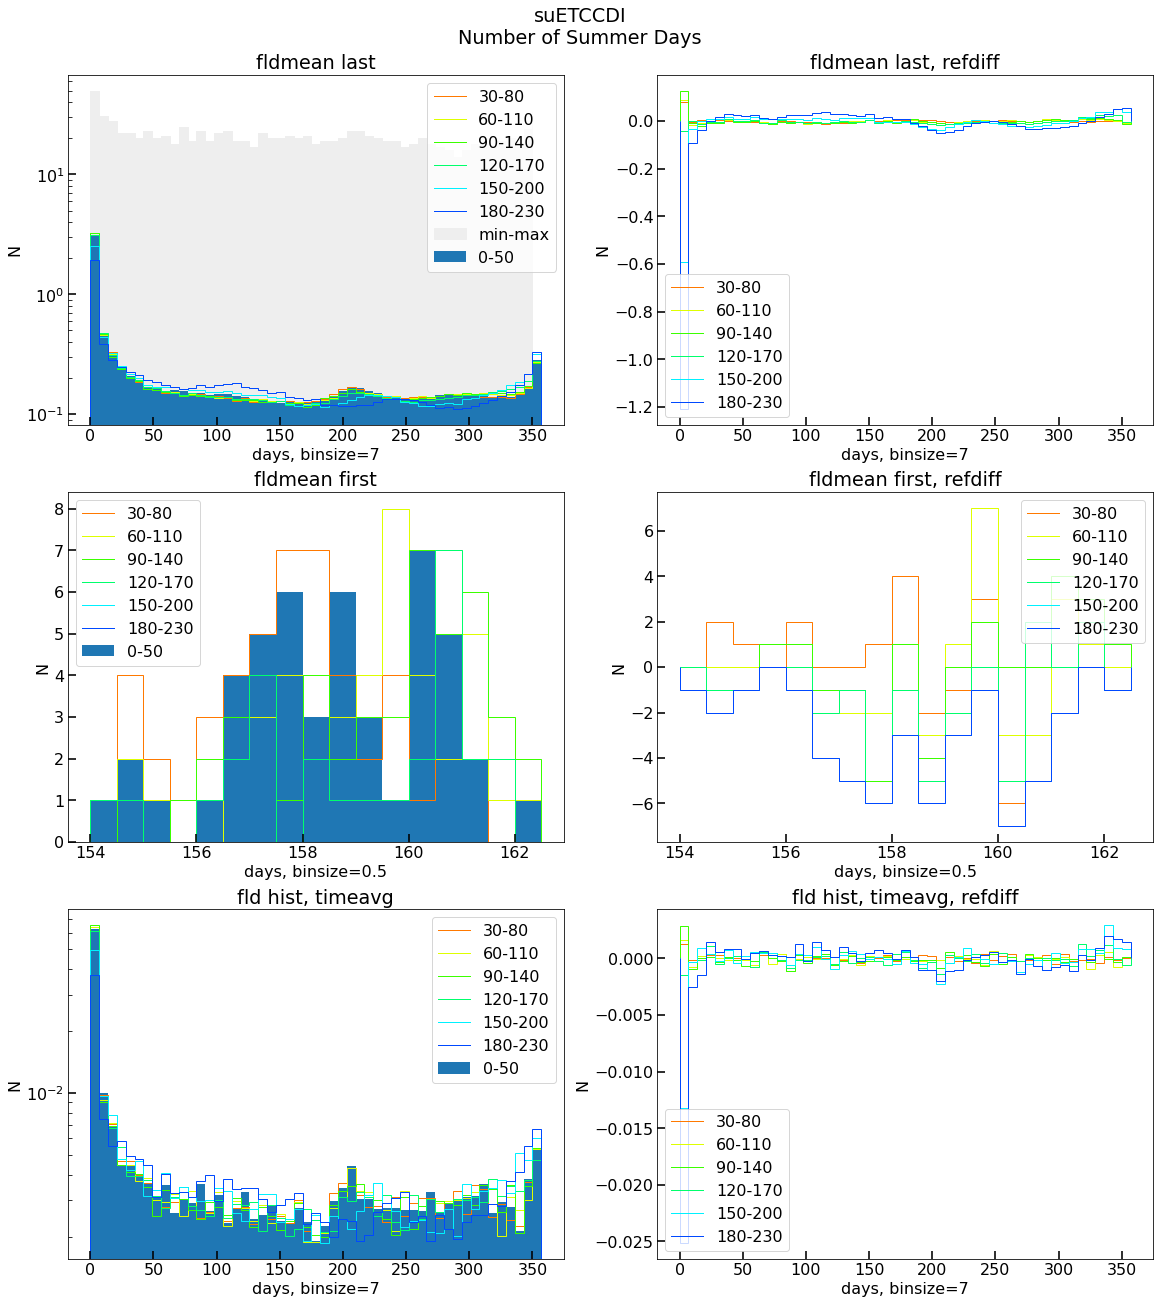

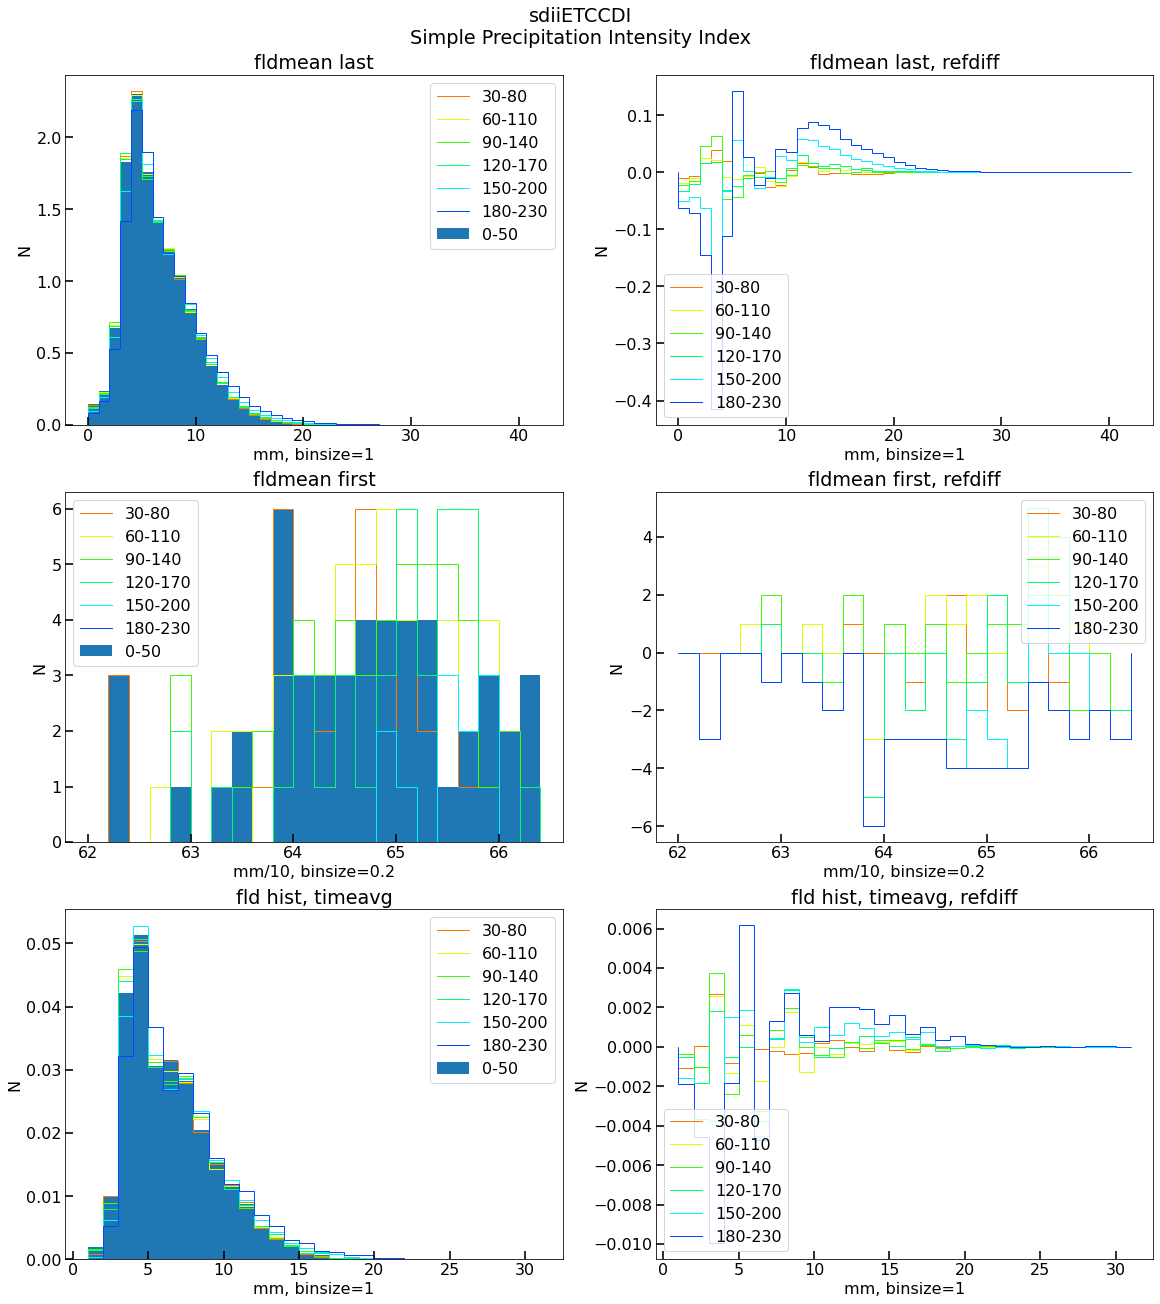

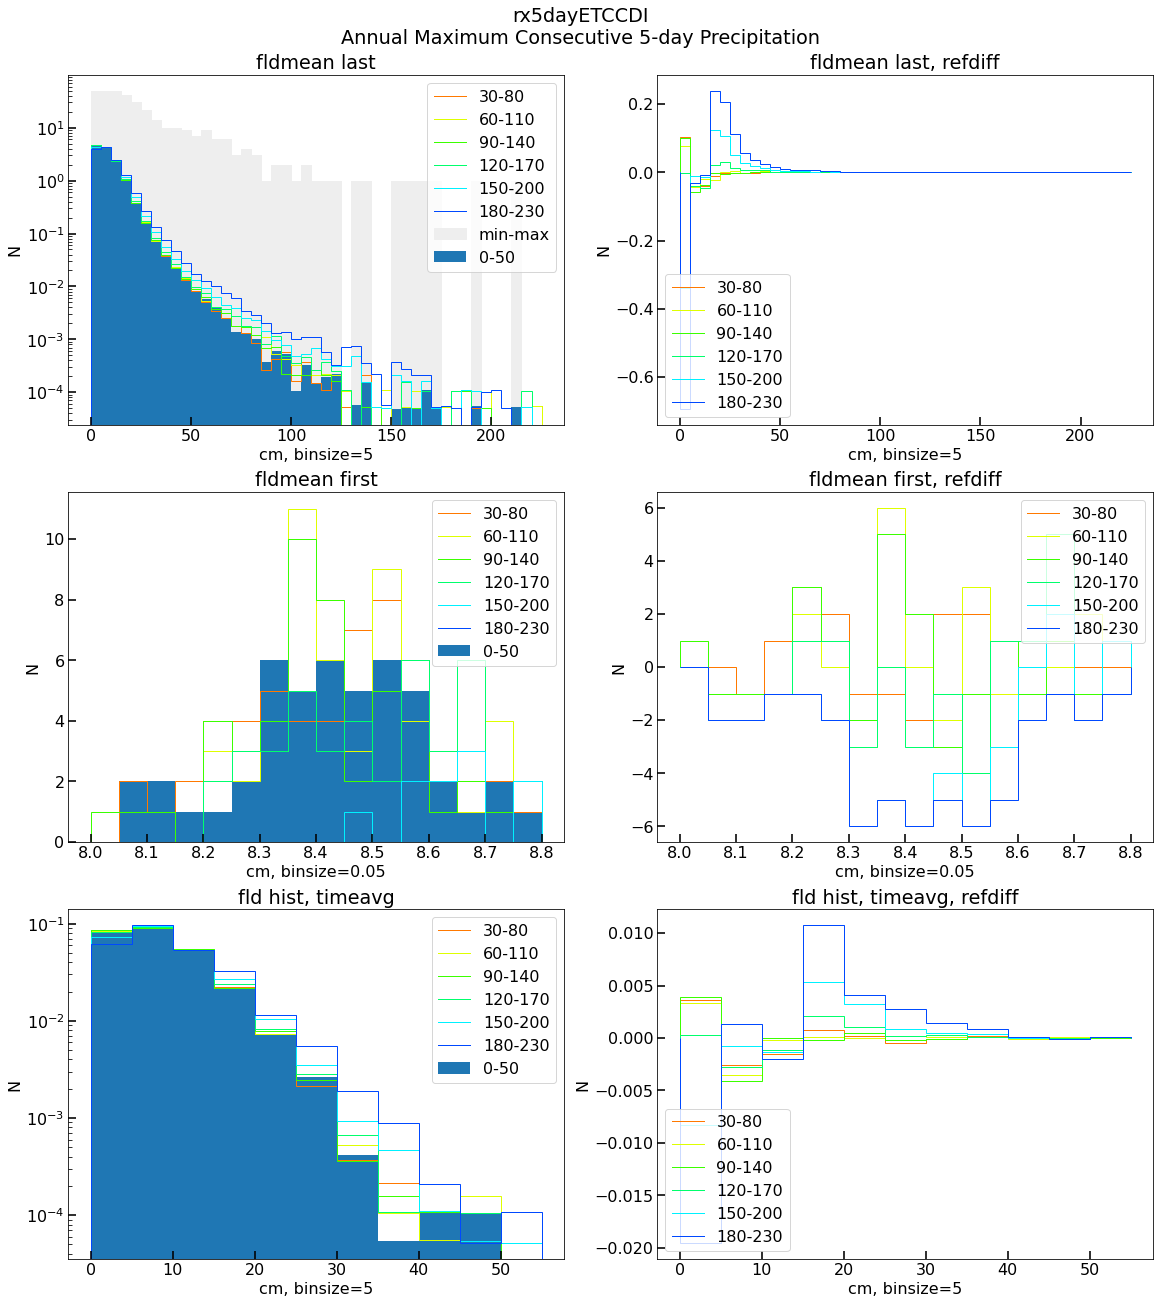

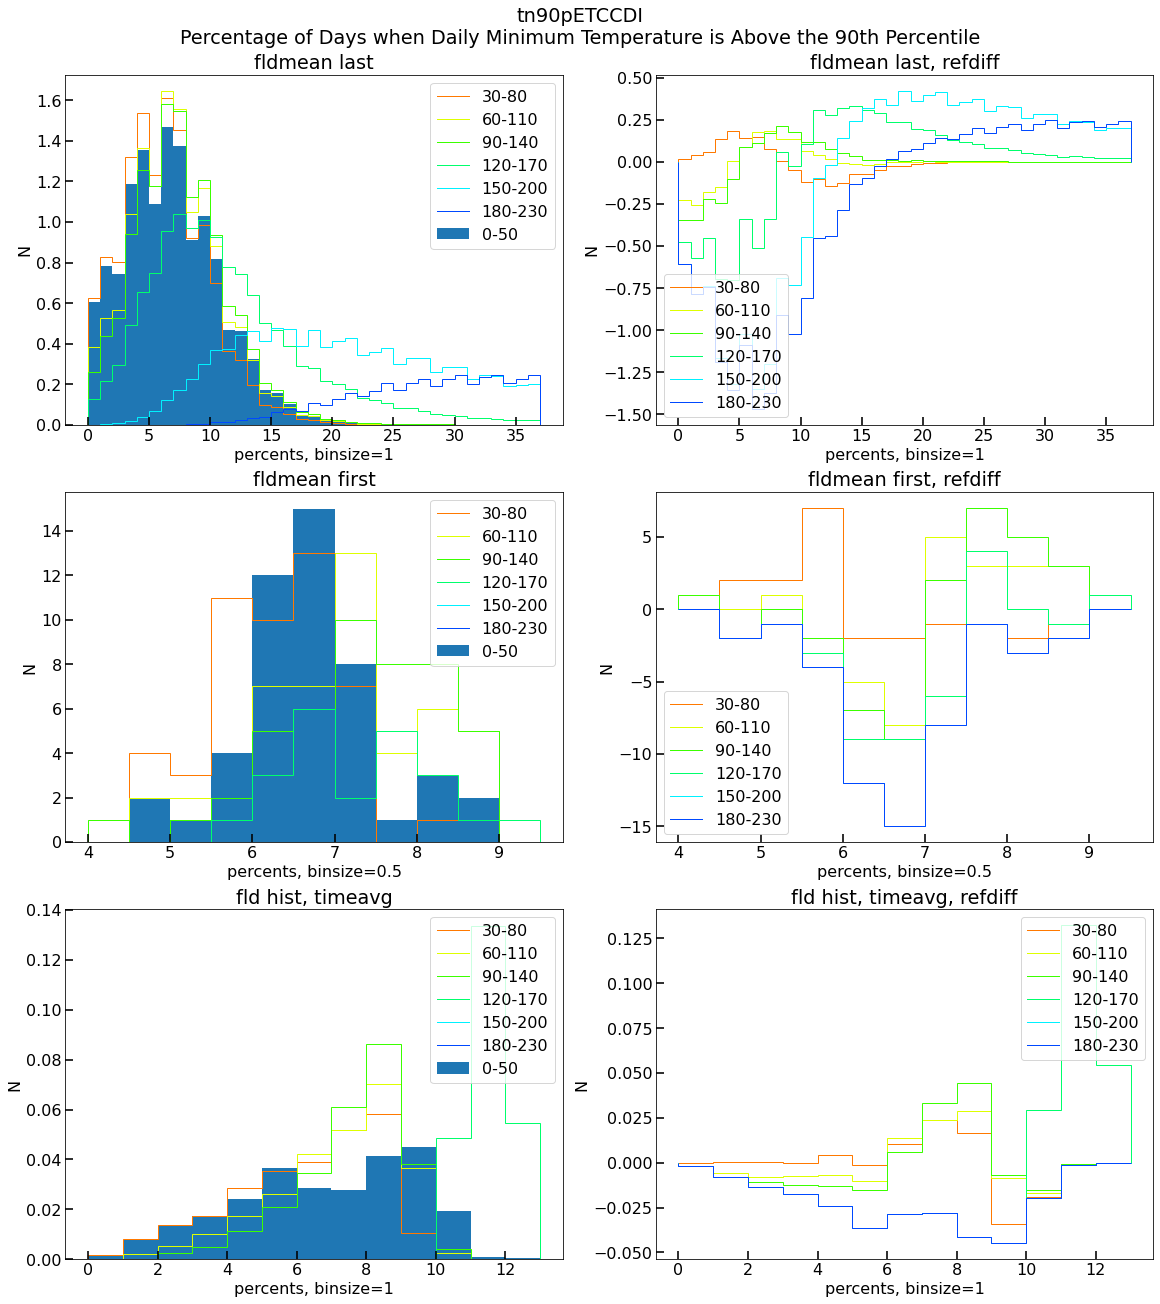

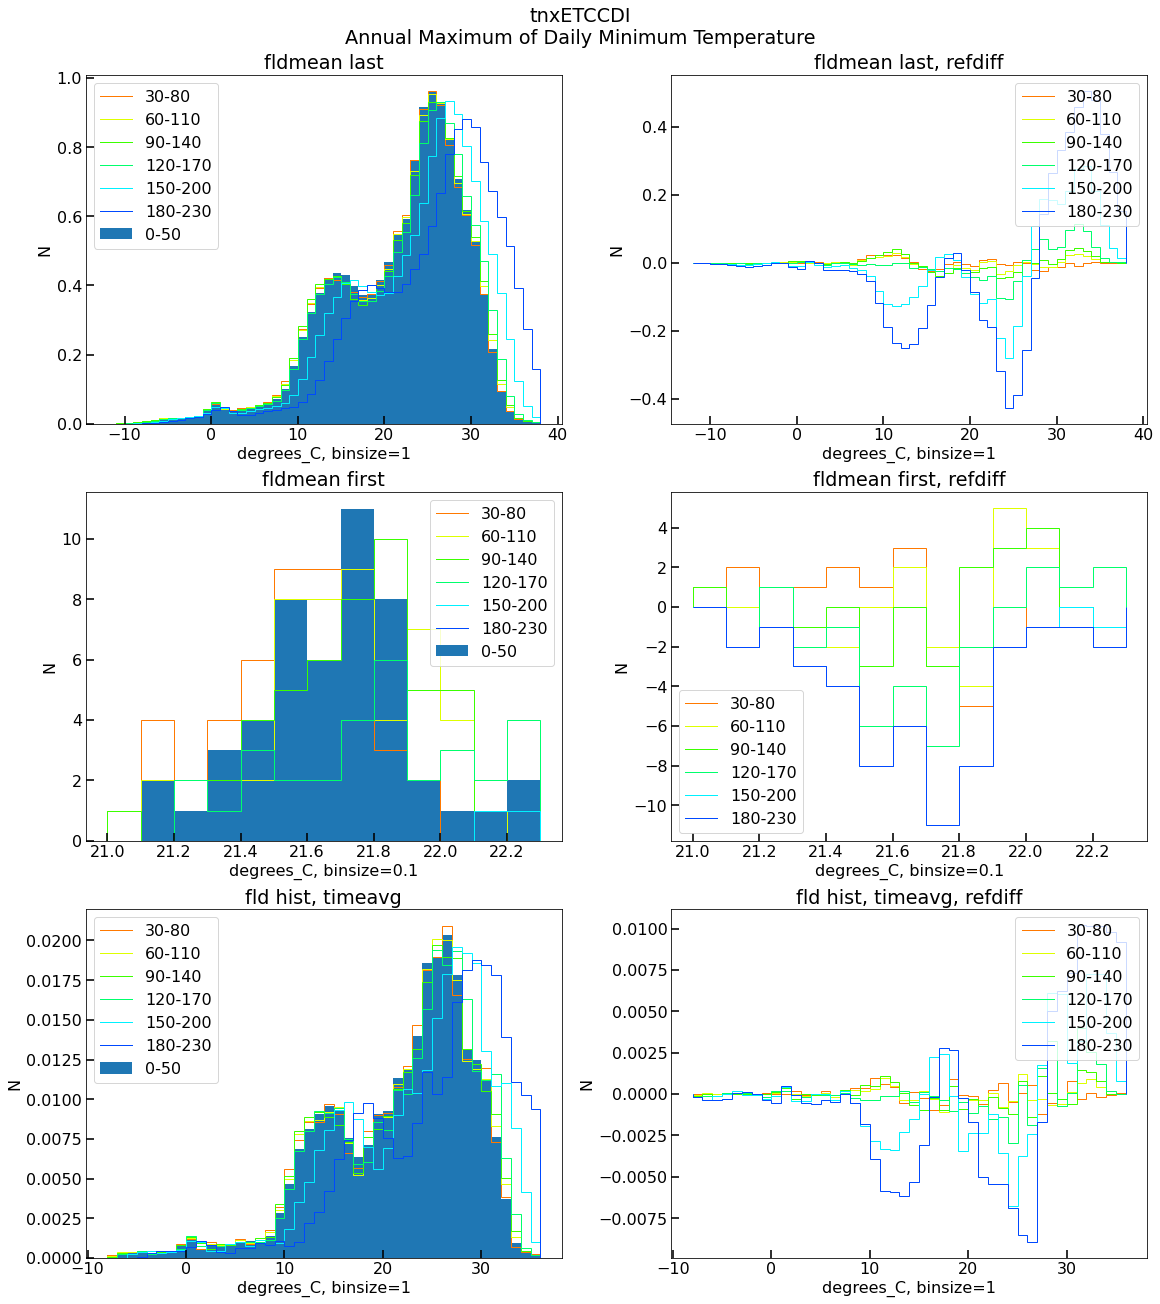

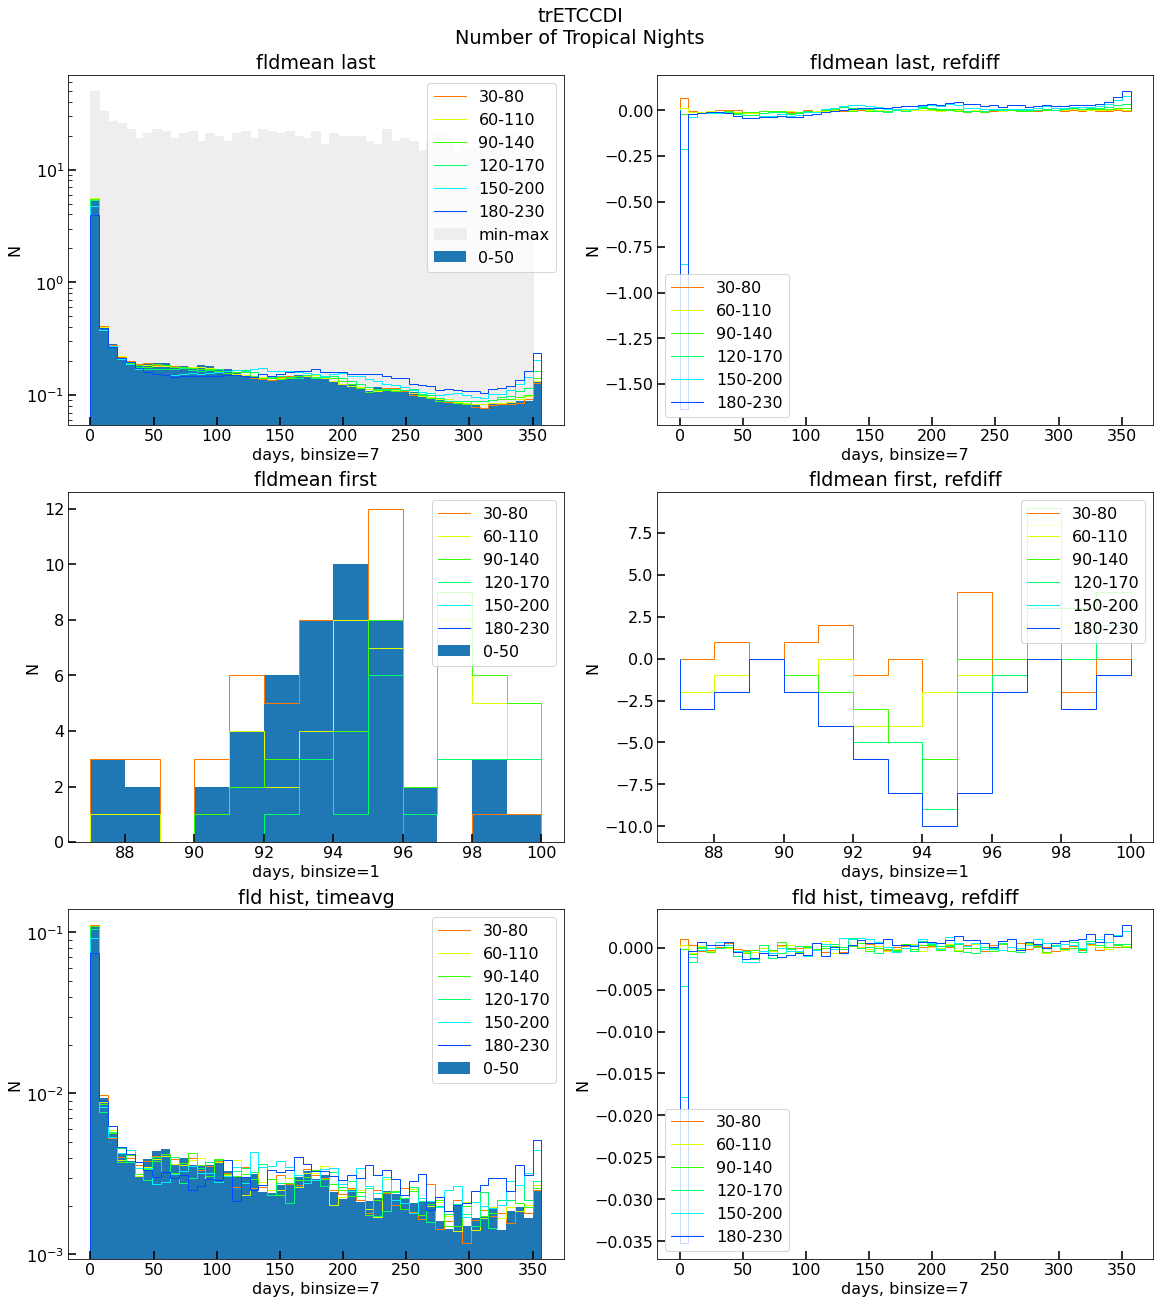

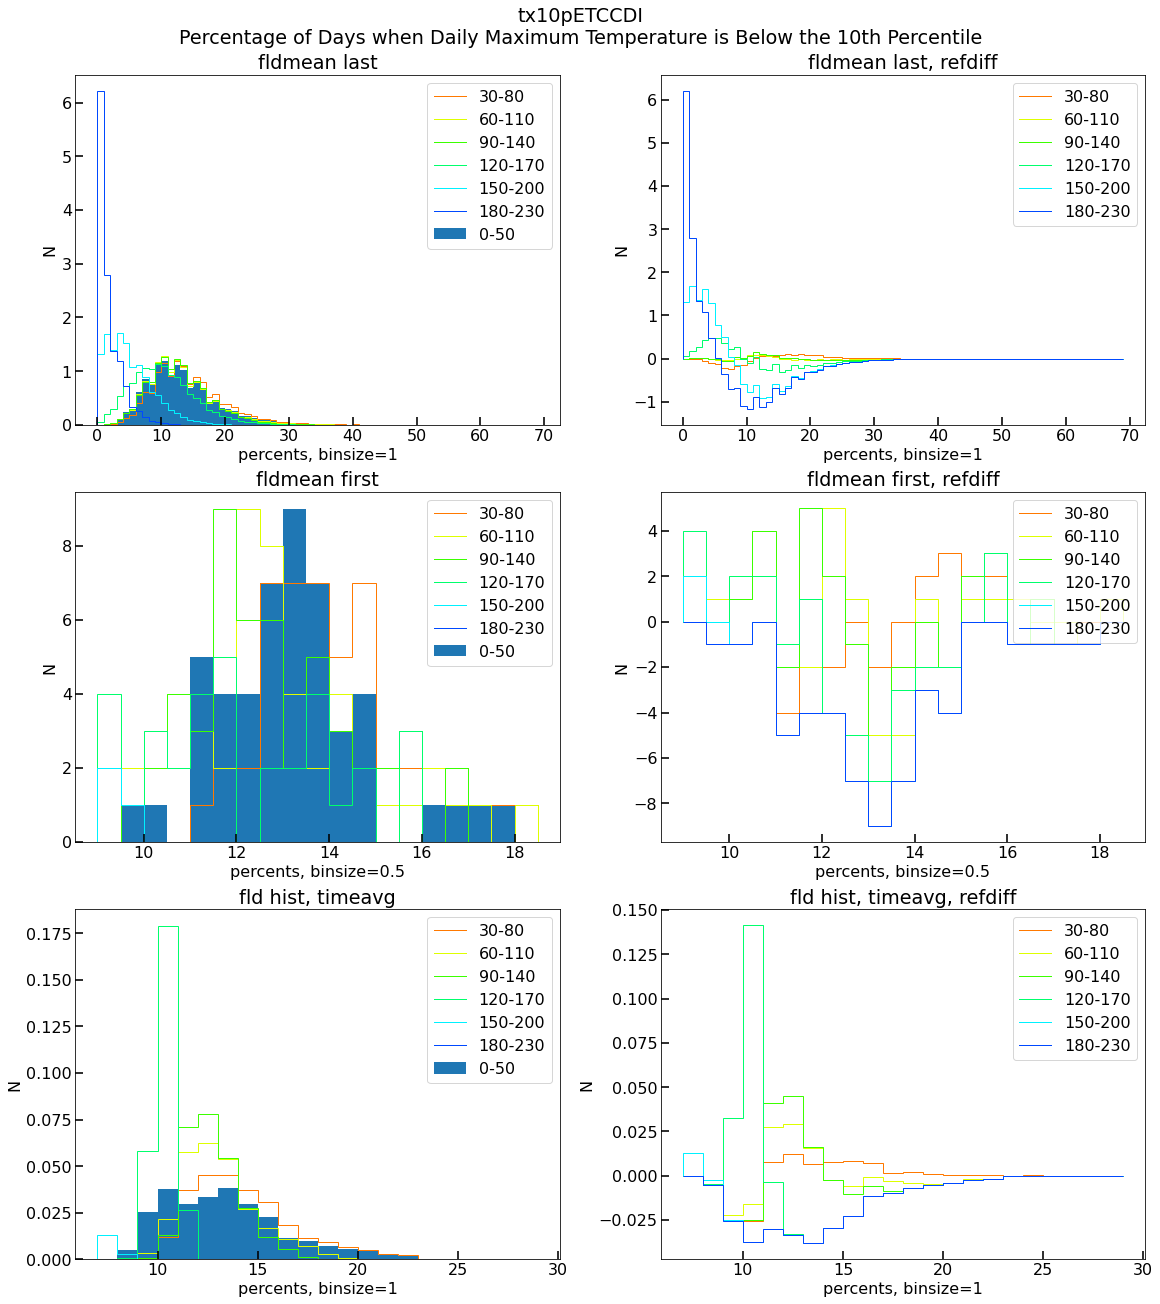

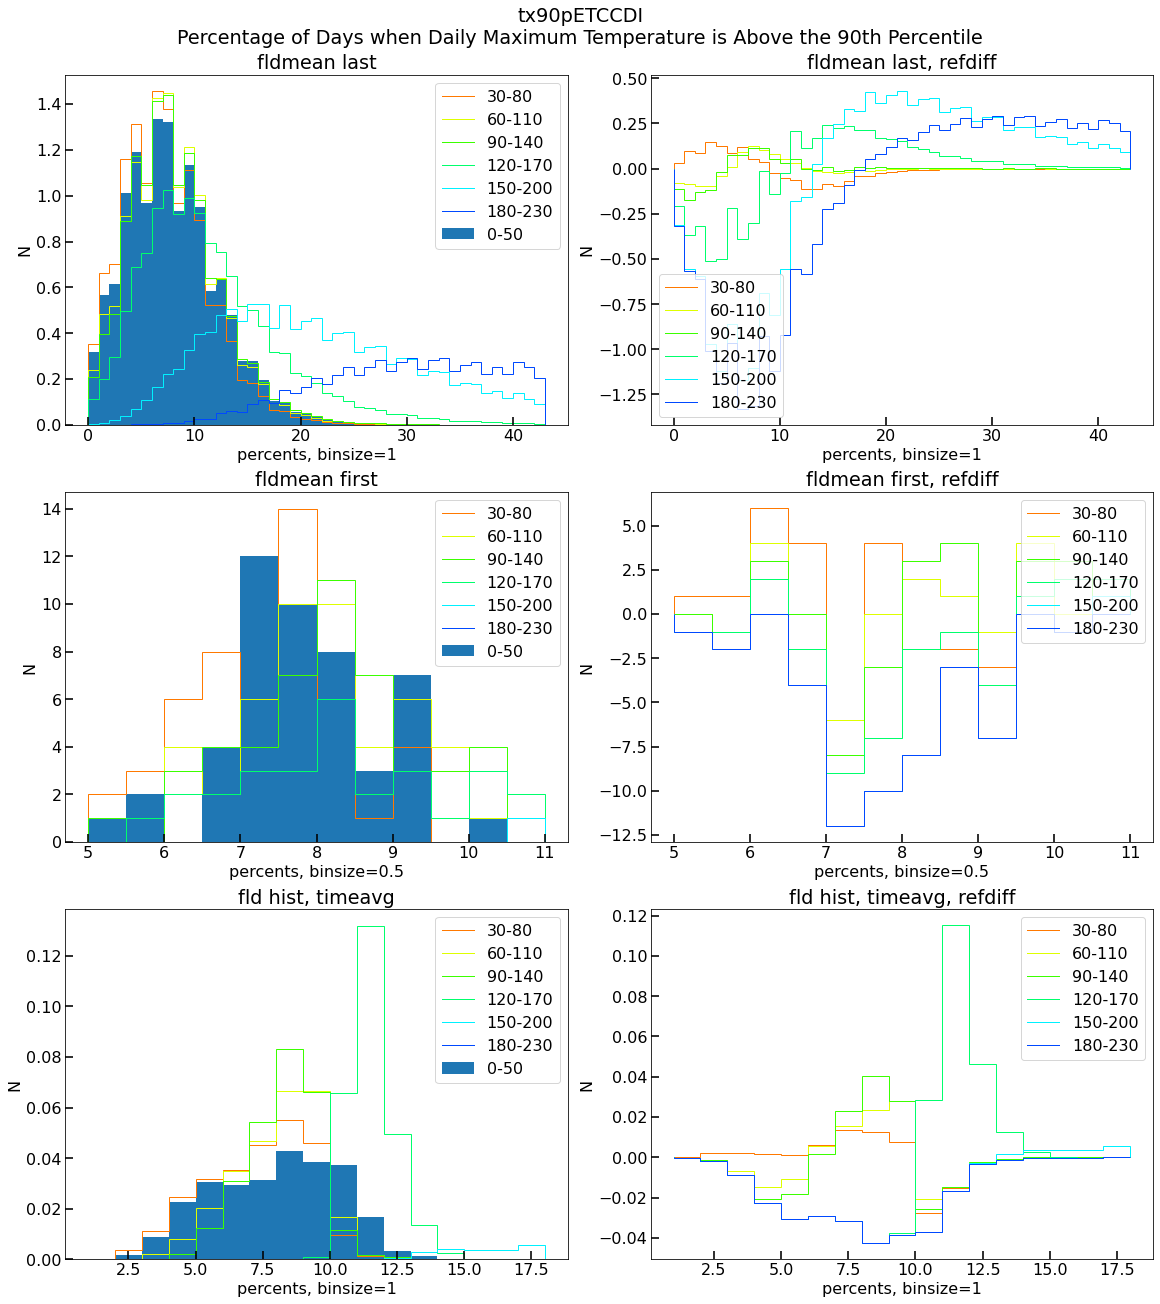

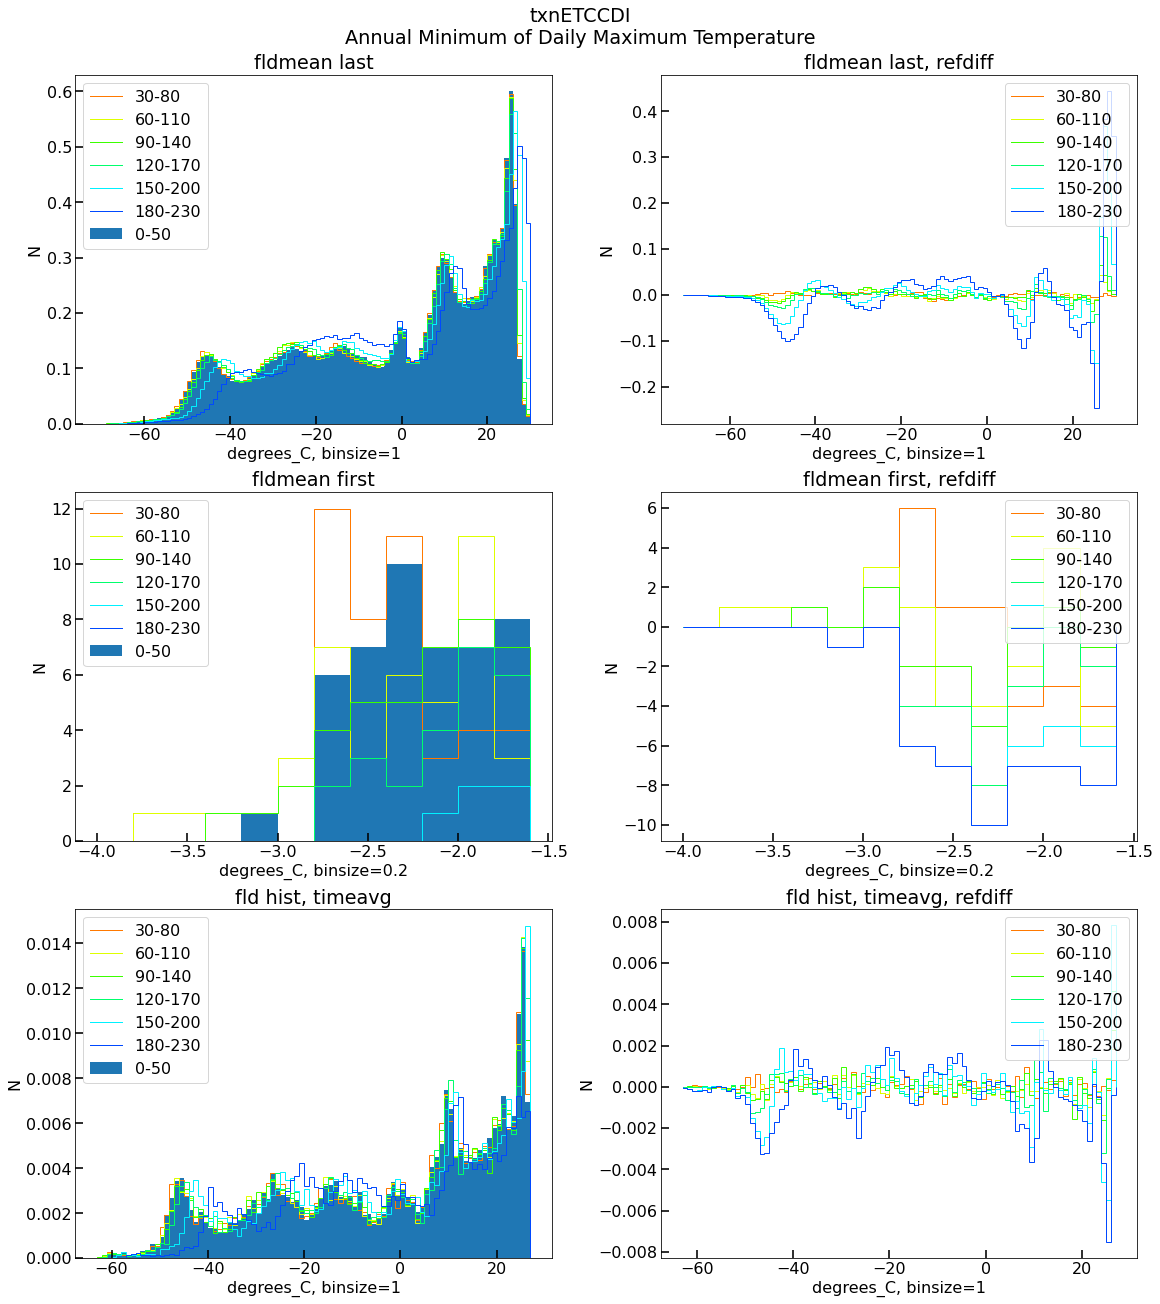

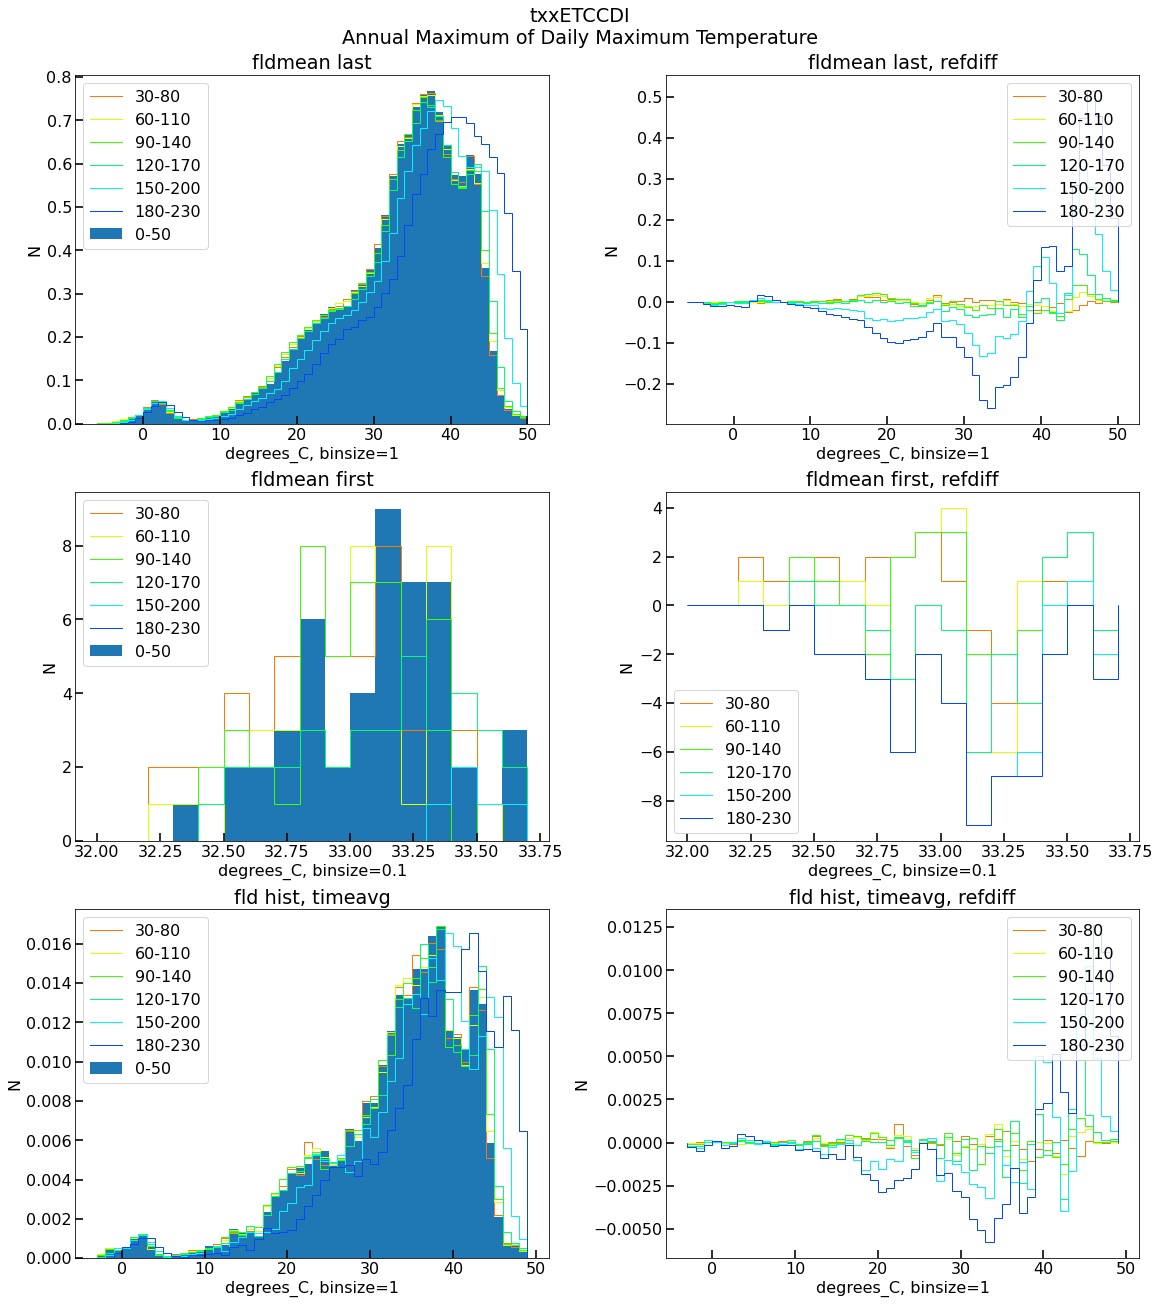

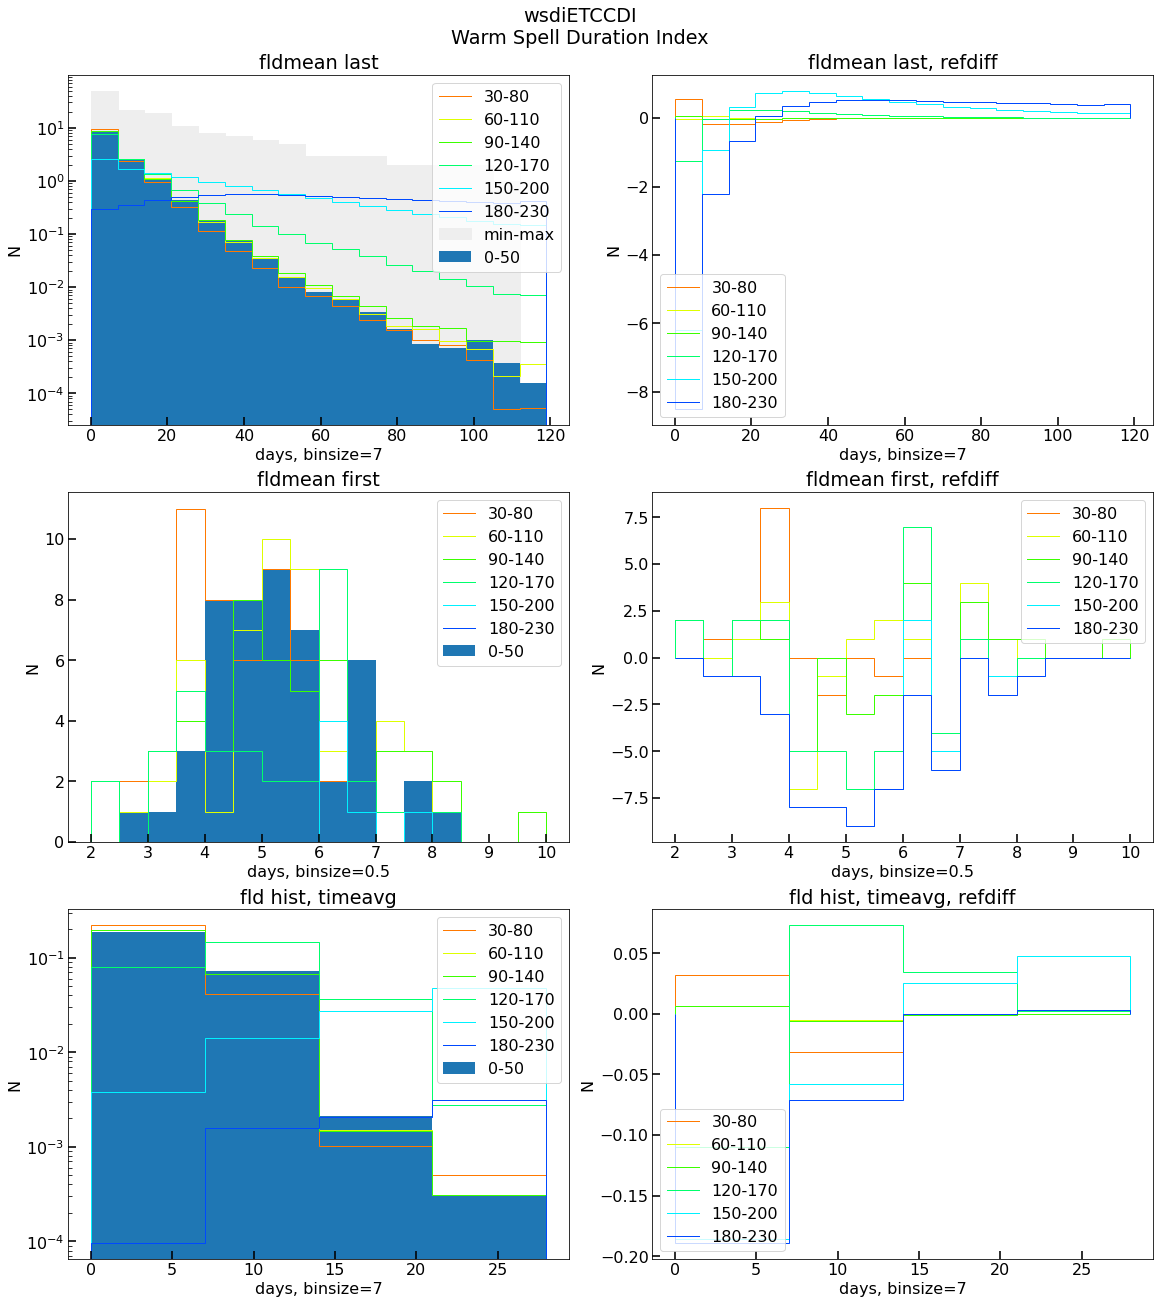

In [8]:
def plot_index_distribution(axes, index, filepath):
    raw_data = xr.load_dataset(filepath)
    idx_long_name = raw_data[index].long_name
    mask = get_oceans_mask(raw_data) & get_antarctica_mask(raw_data)
    data = remove_grid_from_data(raw_data).where(mask)
    #plot_idx_value(data.where(mask), index)
    plot_means_of_hists(axes[0][0], data[index].isel(time=slice(0, None)))
    plot_means_of_hists_diff(axes[0][1], data[index].isel(time=slice(0, None)))
    plot_hists_of_means(axes[1][0], data[index].isel(time=slice(0, None)))
    plot_hists_of_means_diff(axes[1][1], data[index].isel(time=slice(0, None)))
    plot_hist_of_timeavgs(axes[2][0], data[index].isel(time=slice(0, None)))
    plot_hist_of_timeavgs_diff(axes[2][1], data[index].isel(time=slice(0, None)))
    return idx_long_name


def plot_index_distributions(file_infos):
    file_infos.send(None)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    #for fileinfo in files[files["variable"] == "altcddETCCDI"].itertuples():
    while True:
        with tempfile.NamedTemporaryFile() as tmpfile:
            filepath = tmpfile.name
            try:
                filepath, variable = file_infos.send(filepath)
            except StopIteration:
                break
            fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16, 18))
            idx_long_name = plot_index_distribution(ax, variable, filepath)
            fig.suptitle(f"{variable}\n{idx_long_name}")
            display(fig)
            fig.savefig(f"{OUTPUT_DIR}/{variable}.svg")
            plt.close()
        
plot_index_distributions(get_list_of_files(DATASETS, config, with_scenario="ssp585"))